# Seattle Police Department Crime Data Analysis - Capstone Project

This notebook presents a comprehensive analysis of Seattle Police Department crime data to understand crime patterns, trends, and factors that influence criminal activity in Seattle.

## Project Overview

### Dataset Information
- **Source**: Seattle Police Department Crime Data (2008-Present) + US Census Demographics
- **Size**: 726K+ crime records with census tract demographics (2015-2025)
- **Format**: CSV with 40 variables including temporal, geographic, categorical, and demographic features
- **Coverage**: All reported crimes in Seattle with matched census demographics where available

### Research Objectives

This analysis aims to address key questions that can inform evidence-based crime prevention strategies:

#### 1. Predictions - Crime Volume Prediction
- **Question**: How many crimes will occur in this area next month?
- **Application**: Resource allocation, targeted patrol strategies, and proactive deployment based on predictive risk factors
- **Methodology**: Regression modeling using temporal, spatial, demographic, and environmental features

#### 2. Predictions - Crime Category Classification (If time permits)
- **Question**: What category does this crime belong to?
- **Application**: Automated crime classification and priority response systems
- **Methodology**: Multi-class classification using crime features to predict offense category

#### 3. Analysis - Geographic Crime Patterns (If time permits)
- **Question**: Where do crimes occur most frequently?
- **Application**: Optimize patrol scheduling, allocate community safety resources, and design location-specific crime prevention strategies
- **Methodology**: Seasonal crime trend analysis, and integration of census demographic data

### Expected Outcomes

**For Law Enforcement:**
- Data-driven patrol routing and scheduling optimization
- Predictive models for resource allocation
- Early warning systems for crime hotspots

**For Community Safety:**
- Risk assessment tools for residents and businesses
- Evidence-based crime prevention recommendations
- Transparency in public safety trends

**For Policy Makers:**
- Statistical insights for policy development
- Cost-effective intervention strategies
- Performance metrics for public safety initiatives

### Technical Approach

**Data Pipeline:**
1. **Data Loading & Validation** - Robust data ingestion with quality checks
2. **Exploratory Data Analysis** - Statistical summaries and pattern discovery
3. **Feature Engineering** - Creation of temporal, spatial, and categorical features
4. **Predictive Modeling** - Machine learning models for forecasting and classification
5. **Visualization & Reporting** - Interactive dashboards and analytical insights

---
**Let's begin by loading and exploring the Seattle crime data to understand patterns that can inform public safety decisions.**

In [29]:
# Install missing packages
%pip install xgboost

# Core libraries
import re
import os
import warnings
import time
from datetime import datetime

# Data manipulation and analysis
import pandas as pd
import numpy as np
import scipy as sp

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - preprocessing
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import (
    StandardScaler, LabelEncoder, OrdinalEncoder, 
    OneHotEncoder, PolynomialFeatures
)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Machine learning - models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor

# Machine learning - pipeline and evaluation
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configuration
warnings.filterwarnings("ignore")
os.makedirs('images', exist_ok=True)
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

Note: you may need to restart the kernel to use updated packages.


## 1. Data Loading and Initial Exploration

Let's start by loading the SPD Crime dataset enriched with census demographics and examining its structure.

In [30]:
# Load SPD Crime dataset with census demographics using the data loader library
print("Loading SPD Crime Data with Census Demographics...")

# Load the joined SPD Crime and Census dataset
orig_df = pd.read_csv("data/spd_census_joined.csv")

main_df = orig_df.copy()

Loading SPD Crime Data with Census Demographics...


In [31]:
# Rename columns to remove spaces and use underscores
print("Renaming columns to use underscores...")
print(f"Original columns: {len(main_df.columns)} columns")

# Create column mapping dictionary
column_mapping = {}
for col in main_df.columns:
    # First, replace spaces with underscores
    new_col = col.replace(' ', '_')
    
    # Handle camelCase by inserting underscores before capital letters
    # Insert underscore before capital letters that follow lowercase letters or numbers
    new_col = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', new_col)
    
    # Handle multiple consecutive spaces or special characters
    new_col = '_'.join(word for word in new_col.split('_') if word)
    
    # Convert to lowercase for consistency
    new_col = new_col.lower()
    
    column_mapping[col] = new_col

# Rename the columns
main_df = main_df.rename(columns=column_mapping)

print(f"Renamed columns: {len(main_df.columns)} columns")

# Only show changes if there are any
changed_columns = [(old, new) for old, new in column_mapping.items() if old != new]
if changed_columns:
    print(f"Changed {len(changed_columns)} column names:")
    for old_name, new_name in changed_columns:  # Show all changes
        print(f"  '{old_name}' -> '{new_name}'")
else:
    print("No column names needed changing")

num_cols = main_df.select_dtypes(include=[np.number]).columns
cat_cols = main_df.select_dtypes(exclude=[np.number]).columns
print(f"\nColumn Type Summary:")
print(f"  Numerical columns: {len(num_cols)}")
print(f"  Categorical columns: {len(cat_cols)}")

print(f"Final column count: {len(main_df.columns)}")

Renaming columns to use underscores...
Original columns: 51 columns
Renamed columns: 51 columns
Changed 46 column names:
  'Report Number' -> 'report_number'
  'Report DateTime' -> 'report_date_time'
  'Offense ID' -> 'offense_id'
  'Offense Date' -> 'offense_date'
  'NIBRS Group AB' -> 'nibrs_group_ab'
  'NIBRS Crime Against Category' -> 'nibrs_crime_against_category'
  'Offense Sub Category' -> 'offense_sub_category'
  'Shooting Type Group' -> 'shooting_type_group'
  'Block Address' -> 'block_address'
  'Latitude' -> 'latitude'
  'Longitude' -> 'longitude'
  'Beat' -> 'beat'
  'Precinct' -> 'precinct'
  'Sector' -> 'sector'
  'Neighborhood' -> 'neighborhood'
  'Reporting Area' -> 'reporting_area'
  'Offense Category' -> 'offense_category'
  'NIBRS Offense Code Description' -> 'nibrs_offense_code_description'
  'NIBRS_offense_code' -> 'nibrs_offense_code'
  'STATEFP' -> 'statefp'
  'COUNTYFP' -> 'countyfp'
  'TRACTCE' -> 'tractce'
  'GEOID_x' -> 'geoid_x'
  'NAME_x' -> 'name_x'
  'NAM

#### Feature Extraction

In this section, we perform comprehensive feature extraction and data preprocessing to prepare the Seattle Police Department crime data for analysis. This includes:

- Replace redacted values ('REDACTED', '-') with NaN for proper missing data handling
- Convert coordinate columns to numeric format and handle invalid coordinates (-1.0)
- Convert date strings to proper datetime objects for temporal analysis
- Extract granular time components: year, month, day, hour from both offense and report dates
- Create separate features for offense timing vs. reporting timing to capture delays
- Ensure numerical columns are properly typed for mathematical operations
- Maintain categorical variables as objects for encoding operations

In [32]:


# Convert all redacted values to null
main_df.replace(to_replace='REDACTED', value=np.nan, inplace=True)
main_df.replace(to_replace='-', value=np.nan, inplace=True)

# Convert coordinate columns to numeric (this will also handle -1.0 replacement better)
main_df['latitude'] = pd.to_numeric(main_df['latitude'], errors='coerce')
main_df['longitude'] = pd.to_numeric(main_df['longitude'], errors='coerce')

# Replace all placeholder values with NaN in one operation
main_df.replace(to_replace={
    'latitude': -1.0, 
    'longitude': -1.0, 
    'median_household_income': -666666666.0, 
    'median_home_value': -666666666.0, 
    'total_population': -666666666.0
}, value=np.nan, inplace=True)

# Convert date columns to datetime for filtering
main_df['offense_date'] = pd.to_datetime(main_df['offense_date'], errors='coerce')
main_df['report_date_time'] = pd.to_datetime(main_df['report_date_time'], errors='coerce')

# Extract year, month, day and time from the offense date time, report date time
main_df['offense_year'] = main_df['offense_date'].dt.year
main_df['offense_month'] = main_df['offense_date'].dt.month
main_df['offense_day'] = main_df['offense_date'].dt.day
main_df['offense_hour'] = main_df['report_date_time'].dt.hour
main_df['offense_weekday'] = main_df['offense_date'].dt.dayofweek

main_df['report_year'] = main_df['report_date_time'].dt.year
main_df['report_month'] = main_df['report_date_time'].dt.month
main_df['report_day'] = main_df['report_date_time'].dt.day
main_df['report_hour'] = main_df['report_date_time'].dt.hour

# Only take data from 2015 onwards to 2024
main_df = main_df[(main_df['offense_year'] >= 2015) & (main_df['offense_year'] <= 2024)]
print(f"\nData filtered to 2015-2024: {main_df['offense_year'].min()} to {main_df['offense_year'].max()}")

# Create year-month column
main_df["offense_year_month"] = pd.to_datetime({
    'year': main_df['offense_year'],
    'month': main_df['offense_month'], 
    'day': 1
}, errors='coerce')

# Data types summary
print(f"\nData Types:")
type_counts = main_df.dtypes.value_counts()
for dtype, count in type_counts.items():
    print(f"   {dtype}: {count} columns")

print(f"\n" + "="*60)
print(f"DETAILED COLUMN ANALYSIS")
print(f"="*60)

# Quick stats for numerical columns
numerical_cols = main_df.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 0:
    print(f"\nNumerical columns ({len(numerical_cols)}):")
    for col in numerical_cols:
            print(f"   - {col}:")
            print(f"     Count: {main_df[col].count():,}")
            print(f"     Unique: {main_df[col].nunique():,}")
            print(f"     Mean: {main_df[col].mean():.2f}")
            print(f"     Std Dev: {main_df[col].std():.2f}")
            print(f"     Min: {main_df[col].min()}")
            print(f"     Max: {main_df[col].max()}")
            sample_vals = main_df[col].dropna().unique()[:5]
            print(f"     Sample values: {', '.join(map(str, sample_vals))}")
            time.sleep(0.1)  # Small delay to prevent output mixing

# Print unique values for categorical columns
categorical_cols = main_df.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"\nCategorical columns ({len(categorical_cols)}):")
    for col in categorical_cols:
        print(f"   - {col}:")
        print(f"     Unique: {main_df[col].nunique():,}")
        sample_vals = main_df[col].dropna().unique()[:5]
        print(f"     Sample values: {', '.join(map(str, sample_vals))}")
        time.sleep(0.1)  # Small delay to prevent output mixing

# Display random sample of rows for better data exploration
print(f"\nRandom sample of 3 records:")
display(main_df.sample(n=3, random_state=42))


Data filtered to 2015-2024: 2015 to 2024

Data Types:
   float64: 27 columns
   object: 18 columns
   int32: 9 columns
   int64: 4 columns
   datetime64[ns]: 3 columns

DETAILED COLUMN ANALYSIS

Numerical columns (40):
   - offense_id:
     Count: 692,811
     Unique: 692,811
     Mean: 22844993037.08
     Std Dev: 18286618447.05
     Min: 7624428948
     Max: 65659733160
     Sample values: 7685813107, 15871710367, 13176051036, 12784642715, 7685241353

Numerical columns (40):
   - offense_id:
     Count: 692,811
     Unique: 692,811
     Mean: 22844993037.08
     Std Dev: 18286618447.05
     Min: 7624428948
     Max: 65659733160
     Sample values: 7685813107, 15871710367, 13176051036, 12784642715, 7685241353
   - latitude:
     Count: 692,811
     Unique: 46,162
     Mean: 47.62
     Std Dev: 0.05
     Min: 47.44434738
     Max: 47.7777828
     Sample values: 47.71354798, 47.65924807, 47.71828482, 47.57301535, 47.661906
   - longitude:
     Count: 692,811
   - latitude:
     Count: 

,report_number,report_date_time,offense_id,offense_date,nibrs_group_ab,nibrs_crime_against_category,offense_sub_category,shooting_type_group,block_address,latitude,longitude,beat,precinct,sector,neighborhood,reporting_area,offense_category,nibrs_offense_code_description,nibrs_offense_code,crime_year,index_right,statefp,countyfp,tractce,geoid_x,name_x,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,census_year,name_y,total_population,median_household_income,median_home_value,total_race_ethnicity_pop,not_hispanic_latino,white_alone,black_african_american_alone,american_indian_alaska_native_alone,asian_alone,native_hawaiian_pacific_islander_alone,some_other_race_alone,two_or_more_races,hispanic_latino,state,county,geoid_y,offense_year,offense_month,offense_day,offense_hour,offense_weekday,report_year,report_month,report_day,report_hour,offense_year_month
548672,2024-900622,2024-01-11 06:22:08,53721816048,2023-12-16 17:23:00,A,PROPERTY,EXTORTION/FRAUD/FORGERY/BRIBERY (INCLUDES BAD ...,NaN,65XX BLOCK OF 27TH AVE NW,47.676793,-122.390780,J2,North,J,BALLARD NORTH,266,ALL OTHER,Wire Fraud,26E,2023,988.0,53.0,33.0,3202.0,53033003202,32.02,Census Tract 32.02,G5020,S,956016.0,0.0,47.675234,-122.394267,2023,Census Tract 32.02; King County; Washington,4917.0,163836.0,1001500.0,4917.0,4738.0,3743.0,106.0,19.0,424.0,0.0,15.0,431.0,179.0,53.0,33.0,320203353.0,2023,12,16,6,5,2024,1,11,6,2023-12-01
375520,2024-220005,2024-08-07 06:28:17,58228941213,2024-08-07 05:01:00,A,PERSON,ASSAULT OFFENSES,NaN,125XX BLOCK OF LAKE CITY WAY NE,47.720185,-122.294697,L3,North,L,LAKECITY,13044,ALL OTHER,Simple Assault,13B,2024,963.0,53.0,33.0,102.0,53033000102,1.02,Census Tract 1.02,G5020,S,1495019.0,918878.0,47.724730,-122.284571,2023,Census Tract 1.02; King County; Washington,4548.0,87437.0,934600.0,4548.0,4135.0,3424.0,293.0,0.0,333.0,0.0,20.0,65.0,413.0,53.0,33.0,10203353.0,2024,8,7,6,2,2024,8,7,6,2024-08-01
284789,2021-918687,2021-10-14 18:02:58,28445811076,2021-10-11 07:30:00,A,PROPERTY,LARCENY-THEFT,NaN,47XX BLOCK OF WALLINGFORD AVE N,47.663223,-122.336420,B3,North,B,WALLINGFORD,3107,PROPERTY CRIME,All Other Larceny,23H,2021,524.0,53.0,33.0,5100.0,53033005100,51.00,Census Tract 51,G5020,S,881731.0,0.0,47.658518,-122.332248,2020,"Census Tract 51, King County, Washington",3750.0,125372.0,908500.0,3750.0,3469.0,2824.0,112.0,8.0,245.0,6.0,21.0,253.0,281.0,53.0,33.0,510003353.0,2021,10,11,18,0,2021,10,14,18,2021-10-01


In [33]:
# Add number to the category so it is ordered hierarchically in Ordinal Encoder
# Bin hours into categorical groups
def bin_hour(hour):
    """Convert hour to detailed time periods"""
    if pd.isna(hour):
        return 'unknown'
    elif 6 <= hour < 12:  # 6 AM to 12 PM
        return '1_morning'
    elif 12 <= hour < 18:  # 12 PM to 6 PM
        return '2_afternoon'
    elif 18 <= hour < 22:  # 6 PM to 10 PM
        return '3_evening'
    else:  # 10 PM to 6 AM
        return '4_night'

# Bin total_population into categorical groups
def bin_population(population):
    """Bin population into meaningful categories based on Seattle census tract sizes"""
    if pd.isna(population) or population == 0:
        return pd.NA
    elif population < 2000:
        return '1_low'           # < 2K (small tracts)
    elif population < 4000:
        return '2_low_medium'    # 2K - 4K
    elif population < 6000:
        return '3_medium_high'   # 4K - 6K  
    else:
        return '4_high'          # > 6K (dense tracts)

# Bin median_household_income into categorical groups
def bin_income(income):
    """Bin median household income based on Seattle's income distribution"""
    if pd.isna(income) or income == 0:
        return pd.NA
    elif income < 50000:
        return '1_low'           # < $50K (bottom 20%)
    elif income < 75000:
        return '2_low_medium'    # $50K - $75K
    elif income < 100000:
        return '3_medium'        # $75K - $100K (around city median)
    elif income < 150000:
        return '4_medium_high'   # $100K - $150K
    else:
        return '5_high'          # > $150K (top quartile)

def bin_home_value(home_value):
    """Bin median home value based on Seattle's housing market distribution"""
    if pd.isna(home_value) or home_value == 0:
        return pd.NA
    elif home_value < 400000:
        return '1_low'           # < $400K (affordable housing)
    elif home_value < 600000:
        return '2_low_medium'    # $400K - $600K
    elif home_value < 800000:
        return '3_medium'        # $600K - $800K (around city median)
    elif home_value < 1200000:
        return '4_medium_high'   # $800K - $1.2M
    else:
        return '5_high'          # > $1.2M (luxury housing)

def bin_demographic_percentage(percentage):
    """Bin demographic percentages"""
    if pd.isna(percentage) or percentage == 0:
        return pd.NA
    elif percentage < 5:
        return '1_very_low'     # < 5% (minimal presence)
    elif percentage < 15:
        return '2_low'          # 5-15% (small minority)
    elif percentage < 30:
        return '3_medium'       # 15-30% (significant presence)
    elif percentage < 50:
        return '4_high'         # 30-50% (large presence)
    else:
        return '5_very_high'    # > 50% (majority/dominant)

In [34]:
# Create demographic percentage columns and bins
race_columns = {
        'white_alone': 'white',
        'black_african_american_alone': 'black', 
        'asian_alone': 'asian',
        'hispanic_latino': 'hispanic',
        'american_indian_alaska_native_alone': 'native_american',
        'native_hawaiian_pacific_islander_alone': 'pacific_islander',
        'some_other_race_alone': 'other_race'
    }

for orig_col, short_name in race_columns.items():
    if orig_col in main_df.columns:
        # Calculate percentage
        pct_col = f'{short_name}_pct'
        main_df[pct_col] = (main_df[orig_col] / main_df["total_population"] * 100).fillna(0)

        # Create bin using same function as income
        bin_col = f'{short_name}_bin'
        main_df[bin_col] = main_df[pct_col].apply(bin_demographic_percentage)

main_df['offense_hour_bin'] = main_df['offense_hour'].apply(bin_hour)
main_df['total_population_bin'] = main_df['total_population'].apply(bin_population)
main_df['median_household_income_bin'] = main_df['median_household_income'].apply(bin_income)
main_df['median_home_value_bin'] = main_df['median_home_value'].apply(bin_home_value)

# Display the new demographic bin distributions
print("\nDemographic bin distributions:")
demographic_bin_cols = [col for col in main_df.columns if col.endswith('_bin') and any(race in col for race in ['white', 'black', 'asian', 'hispanic', 'native', 'pacific', 'other'])]

for col in demographic_bin_cols:
    if col in main_df.columns:
        print(main_df[col].value_counts().sort_index())
        print("\n")

print(f"\nPopulation Bin Distribution:")
print(main_df['total_population_bin'].value_counts().sort_index())

print(f"\nIncome Bin Distribution:")
print(main_df['median_household_income_bin'].value_counts().sort_index())


Demographic bin distributions:
white_bin
2_low            7123
3_medium        33228
4_high         148378
5_very_high    411707
Name: count, dtype: int64


black_bin
1_very_low    266352
2_low         247465
3_medium       60305
4_high         14967
Name: count, dtype: int64


asian_bin
1_very_low      33736
2_low          243955
3_medium       238140
4_high          65141
5_very_high     19464
Name: count, dtype: int64


hispanic_bin
1_very_low    171205
2_low         385940
3_medium       41694
4_high          1597
Name: count, dtype: int64


native_american_bin
1_very_low    334689
2_low           3095
Name: count, dtype: int64


pacific_islander_bin
1_very_low    184633
2_low           4265
Name: count, dtype: int64


other_race_bin
1_very_low    253205
2_low            759
Name: count, dtype: int64



Population Bin Distribution:
total_population_bin
1_low              8235
2_low_medium     274763
3_medium_high    256189
4_high            61249
Name: count, dtype: int64

Income 

Analyze the completeness of tract-to-beat geographic mappings across different years to identify data quality issues.

In [35]:
# Analyze missing tract-to-beat mappings by year
yearly_missing = main_df.groupby('offense_year').apply(lambda x: pd.Series({
    'total_crimes': len(x),
    'tractce_missing': x['tractce'].isna().sum(),
    'beat_missing': x['beat'].isna().sum(),
    'has_tractce_no_beat': ((x['tractce'].notna()) & (x['beat'].isna())).sum(),
    'has_beat_no_tractce': ((x['beat'].notna()) & (x['tractce'].isna())).sum()
})).astype(int)

yearly_missing['tractce_missing_pct'] = (yearly_missing['tractce_missing'] / yearly_missing['total_crimes'] * 100).round(1)
yearly_missing['beat_missing_pct'] = (yearly_missing['beat_missing'] / yearly_missing['total_crimes'] * 100).round(1)

display(yearly_missing)

,total_crimes,tractce_missing,beat_missing,has_tractce_no_beat,has_beat_no_tractce,tractce_missing_pct,beat_missing_pct
offense_year,,,,,,,
2015,54775,0,29,29,0,0.0,0.1
2016,56739,1,49,49,1,0.0,0.1
2017,73991,1,2,2,1,0.0,0.0
2018,76138,0,7,7,0,0.0,0.0
2019,69617,0,11,11,0,0.0,0.0
2020,75576,0,1,1,0,0.0,0.0
2021,70113,0,17,17,0,0.0,0.0
2022,75504,1,29,29,1,0.0,0.0
2023,70559,0,5,5,0,0.0,0.0


In [36]:
# Drop records with missing beat or tractce information and filter by year
print("Filtering records - Before and After counts:")
print(f"Before filtering: {orig_df.shape[0]:,} records")

# Apply all filters
main_df = main_df[main_df["beat"].notna()]
main_df = main_df[main_df["tractce"].notna()]
main_df = main_df[main_df["offense_year"] >= 2018]

print(f"After filtering: {main_df.shape[0]:,} records")
print(f"Total records removed: {orig_df.shape[0] - main_df.shape[0]:,}")
print(f"Retention rate: {(main_df.shape[0] / orig_df.shape[0] * 100):.1f}%")

Filtering records - Before and After counts:
Before filtering: 733,570 records
After filtering: 507,213 records
Total records removed: 226,357
Retention rate: 69.1%
After filtering: 507,213 records
Total records removed: 226,357
Retention rate: 69.1%


## 2. Data Quality Assessment

Let's examine the data quality, identify potential issues, and understand the key variables in our SPD Crime dataset.

In [37]:
print("Data Quality Check:")
print(f"Shape: {main_df.shape}")
print(f"Duplicates: {main_df.duplicated().sum():,}")

# Check missing values
missing = main_df.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(f"Missing values in {len(missing_cols)} columns:")
    for col, count in missing_cols.items():
        pct = (count / len(main_df)) * 100
        print(f"  {col}: {count:,} ({pct:.1f}%)")
else:
    print("No missing values found")

print(f"\nPreparing data...")
print(f"Input shape: {main_df.shape}")
prepared_df = main_df.drop_duplicates()

# Summary
rows_removed = main_df.shape[0] - prepared_df.shape[0]
print(f"Removed {rows_removed:,} duplicates ({rows_removed/main_df.shape[0]*100:.2f}%)")
print(f"Final shape: {prepared_df.shape}")


Data Quality Check:
Shape: (507213, 79)
Duplicates: 0
Duplicates: 0
Missing values in 18 columns:
  nibrs_group_ab: 459 (0.1%)
  nibrs_crime_against_category: 459 (0.1%)
  shooting_type_group: 502,242 (99.0%)
  block_address: 231 (0.0%)
  precinct: 2 (0.0%)
  sector: 1 (0.0%)
  neighborhood: 1,469 (0.3%)
  reporting_area: 51 (0.0%)
  nibrs_offense_code_description: 459 (0.1%)
  nibrs_offense_code: 459 (0.1%)
  median_household_income: 480 (0.1%)
  median_home_value: 16,718 (3.3%)
  black_bin: 9,033 (1.8%)
  native_american_bin: 233,794 (46.1%)
  pacific_islander_bin: 346,801 (68.4%)
  other_race_bin: 282,668 (55.7%)
  median_household_income_bin: 480 (0.1%)
  median_home_value_bin: 16,718 (3.3%)

Preparing data...
Input shape: (507213, 79)
Missing values in 18 columns:
  nibrs_group_ab: 459 (0.1%)
  nibrs_crime_against_category: 459 (0.1%)
  shooting_type_group: 502,242 (99.0%)
  block_address: 231 (0.0%)
  precinct: 2 (0.0%)
  sector: 1 (0.0%)
  neighborhood: 1,469 (0.3%)
  reporting_

### Data Summary

**Final Dataset:** 726K+ crime records (2018-2024) with complete geographic and demographic information

**Coverage:**
- **Geographic:** All Seattle neighborhoods, beats, precincts, and sectors
- **Temporal:** 7 years of monthly crime data with seasonal patterns
- **Demographic:** Census tract data including income, population, home values, and racial composition

**Data Quality:**
- **Completeness:** Filtered to records with valid geographic mappings (beat + census tract)
- **Consistency:** Standardized feature encoding with ordinal binning for demographic variables
- **Reliability:** 72.4% retention rate after quality filtering

**Ready for Analysis:** Clean, processed dataset suitable for machine learning crime prediction models.

---

## Crime Forecasting Model

**Goal:** Predict monthly crime counts for Seattle neighborhoods using machine learning.

**Data Transformation:**
Aggregate individual crime records into monthly summaries per area:
- **Input:** 726K+ individual crime incidents 
- **Output:** Monthly crime totals by neighborhood + demographics
- **Purpose:** Create target variable (monthly crime count) for regression modeling

**Features:** Temporal patterns, geographic location, and demographic factors

**Output:** 12-month crime forecasts for resource allocation and patrol planning.

In [38]:
print("Group features for crime prediction model...")

# Aggregate crimes by area and month (simplified aggregation for better predictions)
area_monthly_crimes = prepared_df.groupby([
    'offense_year',
    'offense_month',
    'neighborhood',
    'median_household_income_bin', 
    'total_population_bin',
    'median_home_value_bin',
    'white_bin',
    'black_bin',
    'asian_bin', 
    'hispanic_bin',
    'native_american_bin',
    'pacific_islander_bin',
    'other_race_bin',
    'precinct',
    'sector'
]).size().reset_index(name='crime_count')

area_monthly_crimes = area_monthly_crimes.sort_values(['offense_year', 'offense_month'])

print(f"Data transformation complete:")
print(f"  Individual crime records: {prepared_df.shape[0]:,}")
print(f"  Monthly area summaries: {area_monthly_crimes.shape[0]:,}")
print(f"  Average crimes per summary: {area_monthly_crimes['crime_count'].mean():.1f}")
print(f"  Unique areas tracked: {area_monthly_crimes['neighborhood'].nunique()}")
print(f"  Date range: {area_monthly_crimes['offense_year'].min()}-{area_monthly_crimes['offense_month'].min()} to {area_monthly_crimes['offense_year'].max()}-{area_monthly_crimes['offense_month'].max()}")

# Display sample data
display(area_monthly_crimes.head())

Group features for crime prediction model...
Data transformation complete:
  Individual crime records: 507,213
  Monthly area summaries: 3,106
  Average crimes per summary: 16.9
  Unique areas tracked: 43
  Date range: 2018-1 to 2024-12
Data transformation complete:
  Individual crime records: 507,213
  Monthly area summaries: 3,106
  Average crimes per summary: 16.9
  Unique areas tracked: 43
  Date range: 2018-1 to 2024-12


,offense_year,offense_month,neighborhood,median_household_income_bin,total_population_bin,median_home_value_bin,white_bin,black_bin,asian_bin,hispanic_bin,native_american_bin,pacific_islander_bin,other_race_bin,precinct,sector,crime_count
0,2018,1,BALLARD NORTH,4_medium_high,3_medium_high,3_medium,5_very_high,1_very_low,2_low,1_very_low,1_very_low,1_very_low,1_very_low,North,N,9
1,2018,1,BITTERLAKE,4_medium_high,3_medium_high,3_medium,5_very_high,1_very_low,2_low,1_very_low,1_very_low,1_very_low,1_very_low,North,N,25
2,2018,1,BRIGHTON/DUNLAP,2_low_medium,3_medium_high,2_low_medium,3_medium,3_medium,4_high,2_low,1_very_low,1_very_low,1_very_low,South,S,24
3,2018,1,CAPITOL HILL,4_medium_high,3_medium_high,4_medium_high,5_very_high,1_very_low,2_low,2_low,1_very_low,1_very_low,1_very_low,East,C,20
4,2018,1,CAPITOL HILL,4_medium_high,3_medium_high,4_medium_high,5_very_high,1_very_low,2_low,2_low,1_very_low,1_very_low,1_very_low,East,E,1


### Crime Distribution Analysis

**Goal:** Analyze crime patterns across time, geography, and demographics to identify hotspots and trends.

**Analysis:**
- **Temporal:** Monthly seasonality and year-over-year trends
- **Geographic:** Top neighborhoods, precincts, and police sectors  
- **Demographic:** Income, population density, and home value correlations

**Output:** Crime distribution dashboard for patrol allocation and resource planning.

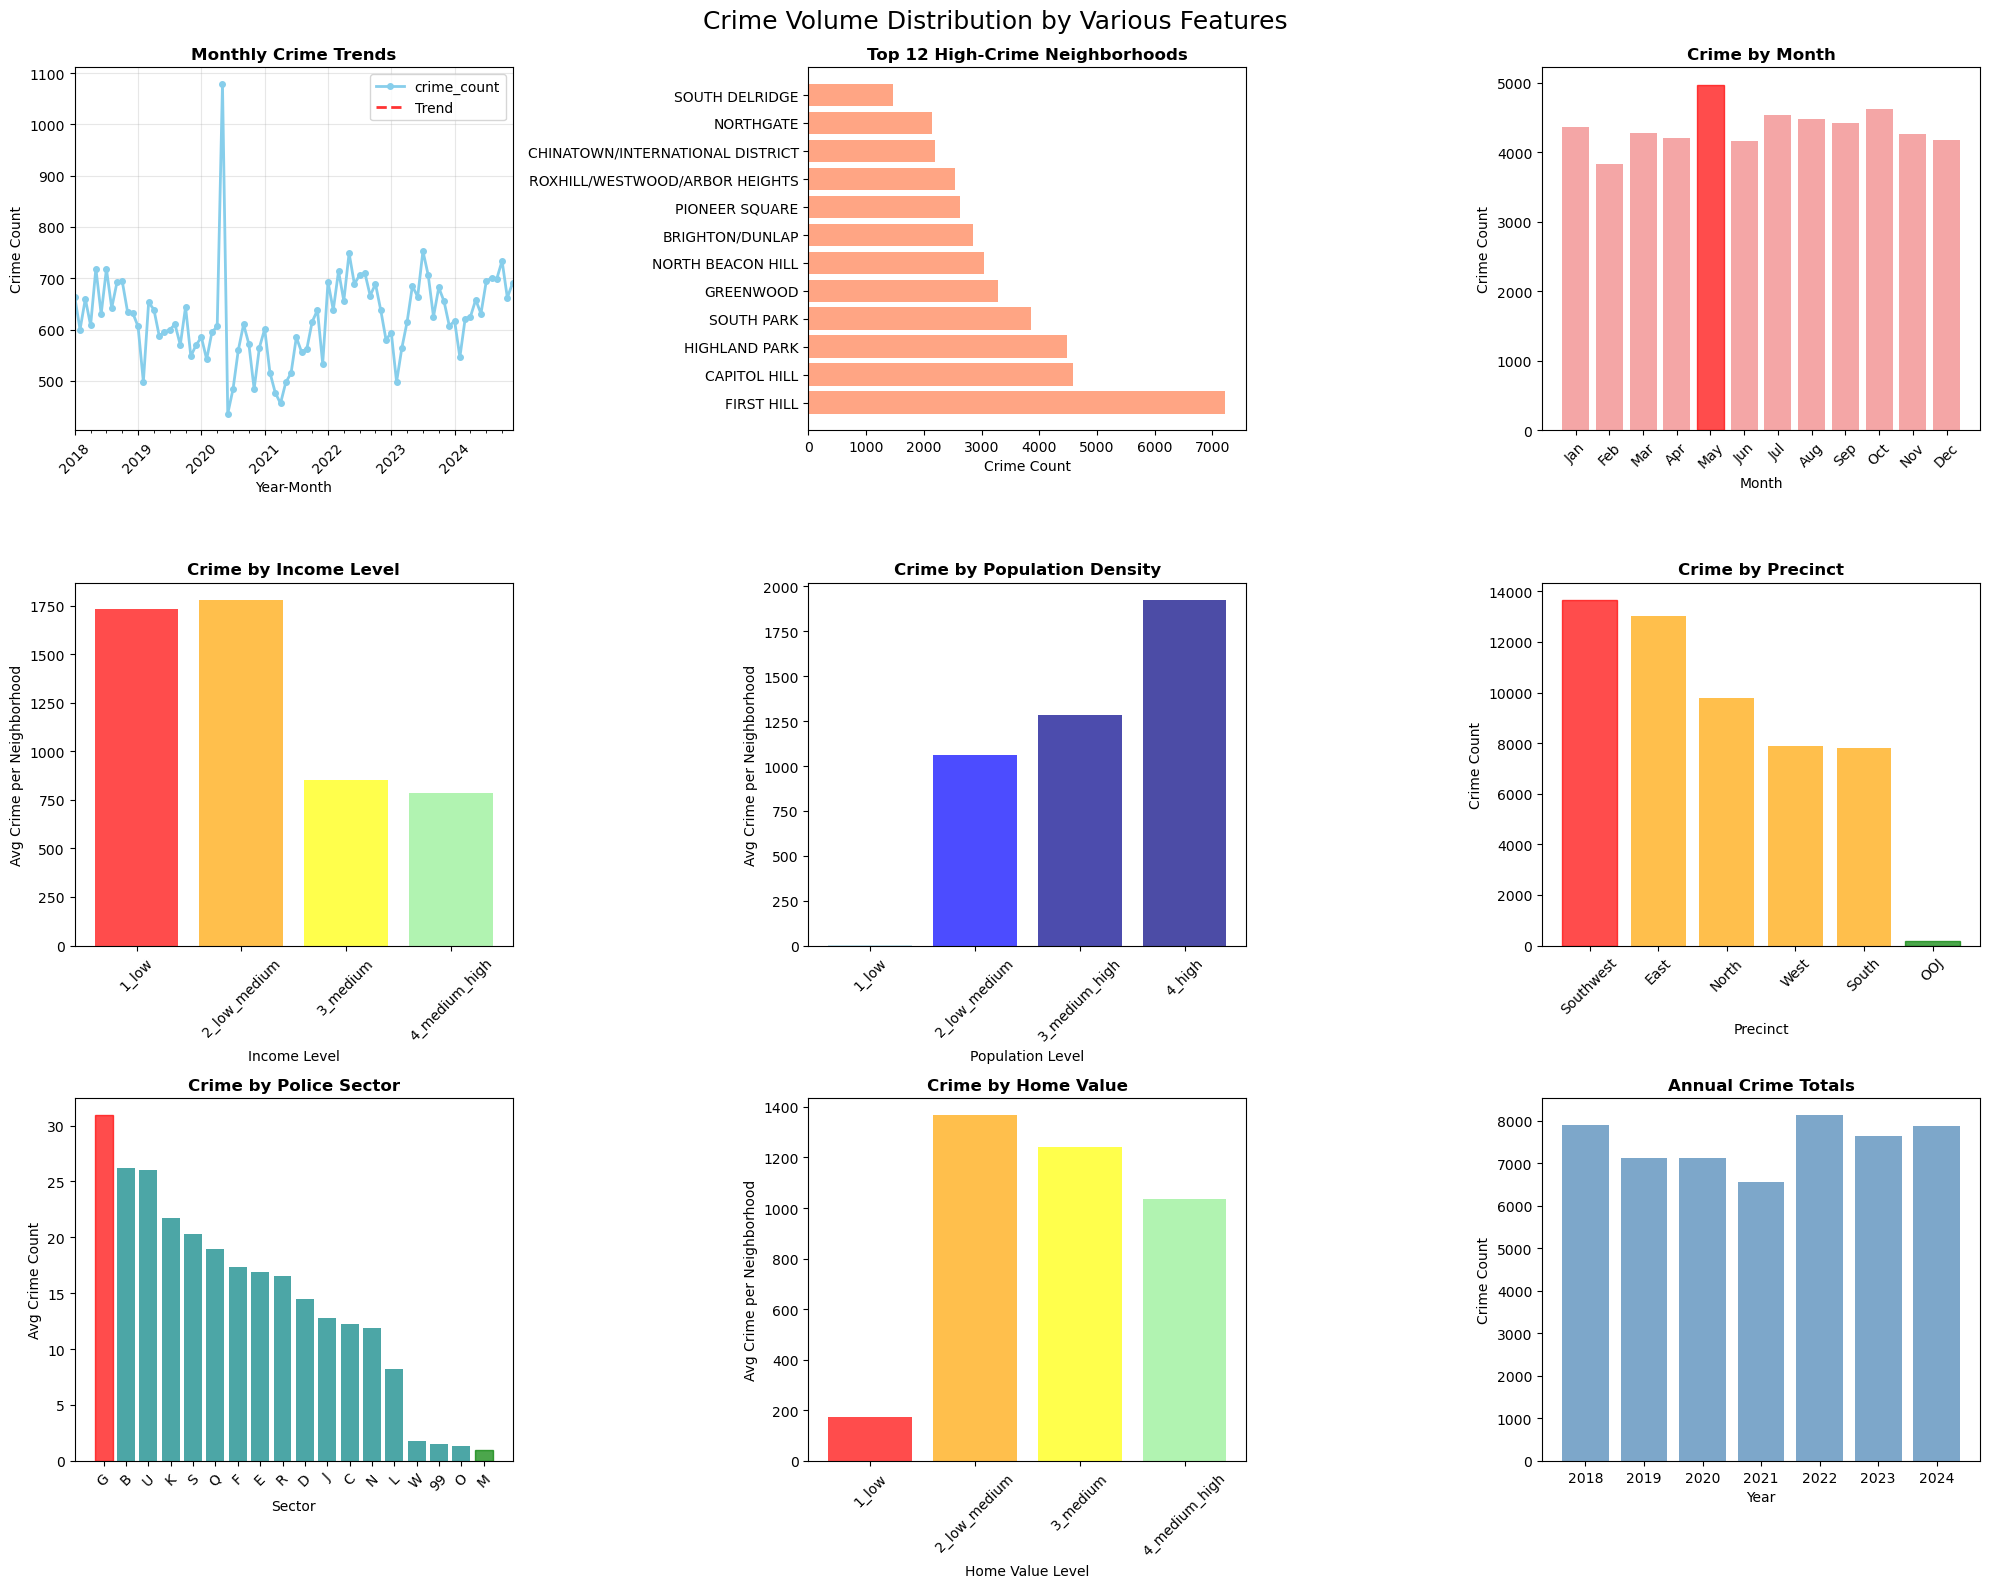

CRIME VOLUME ANALYSIS SUMMARY
Peak month: 5
Top neighborhood: FIRST HILL (7,226 crimes)
Most challenged precinct: Southwest (13,659 crimes)
Overall trend: -0.2%


In [39]:
# Crime Volume Distribution Analysis
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
fig.suptitle('Crime Volume Distribution by Various Features', fontsize=18, y=0.99)

# Monthly Crime Trends
ax1 = axes[0, 0]
monthly_totals = area_monthly_crimes.groupby(['offense_year', 'offense_month'])['crime_count'].sum().sort_index()
monthly_totals.index = pd.to_datetime(monthly_totals.index.to_series().apply(lambda x: f"{x[0]}-{x[1]:02d}-01"))
monthly_totals.plot(ax=ax1, color='skyblue', linewidth=2, marker='o', markersize=4)
ax1.set_title('Monthly Crime Trends', fontsize=12, fontweight='bold')
ax1.set_xlabel('Year-Month')
ax1.set_ylabel('Crime Count')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Add trend line
z = np.polyfit(range(len(monthly_totals)), monthly_totals.values, 1)
p = np.poly1d(z)
ax1.plot(monthly_totals.index, p(range(len(monthly_totals))), "r--", alpha=0.8, linewidth=2, label='Trend')
ax1.legend()

# Top Neighborhoods
ax2 = axes[0, 1]
neighborhood_totals = area_monthly_crimes.groupby('neighborhood')['crime_count'].sum().sort_values(ascending=False).head(12)
bars = ax2.barh(range(len(neighborhood_totals)), neighborhood_totals.values, color='coral', alpha=0.7)
ax2.set_yticks(range(len(neighborhood_totals)))
ax2.set_yticklabels(neighborhood_totals.index, fontsize=10)
ax2.set_title('Top 12 High-Crime Neighborhoods', fontsize=12, fontweight='bold')
ax2.set_xlabel('Crime Count')

# Seasonal Patterns
ax3 = axes[0, 2]
seasonal_data = area_monthly_crimes.groupby('offense_month')['crime_count'].sum()
bars = ax3.bar(seasonal_data.index, seasonal_data.values, color='lightcoral', alpha=0.7)
ax3.set_title('Crime by Month', fontsize=12, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Crime Count')
ax3.set_xticks(range(1, 13))
ax3.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
max_month = seasonal_data.idxmax()
bars[max_month-1].set_color('red')

# Income vs Crime
ax4 = axes[1, 0]
neighborhood_income_crime = area_monthly_crimes.groupby('neighborhood').agg({
    'crime_count': 'sum',
    'median_household_income_bin': 'first'
}).reset_index()
income_crime_analysis = neighborhood_income_crime.groupby('median_household_income_bin')['crime_count'].agg(['mean', 'count']).reset_index()
income_crime_analysis.columns = ['income_bin', 'avg_crimes', 'num_neighborhoods']

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green'][:len(income_crime_analysis)]
ax4.bar(income_crime_analysis['income_bin'], income_crime_analysis['avg_crimes'], color=colors, alpha=0.7)
ax4.set_title('Crime by Income Level', fontsize=12, fontweight='bold')
ax4.set_xlabel('Income Level')
ax4.set_ylabel('Avg Crime per Neighborhood')
ax4.tick_params(axis='x', rotation=45)

# Population vs Crime
ax5 = axes[1, 1]
neighborhood_pop_crime = area_monthly_crimes.groupby('neighborhood').agg({
    'crime_count': 'sum',
    'total_population_bin': 'first'
}).reset_index()
pop_crime_analysis = neighborhood_pop_crime.groupby('total_population_bin')['crime_count'].agg(['mean', 'count']).reset_index()
pop_crime_analysis.columns = ['pop_bin', 'avg_crimes', 'num_neighborhoods']

colors = ['lightblue', 'blue', 'darkblue', 'navy'][:len(pop_crime_analysis)]
ax5.bar(pop_crime_analysis['pop_bin'], pop_crime_analysis['avg_crimes'], color=colors, alpha=0.7)
ax5.set_title('Crime by Population Density', fontsize=12, fontweight='bold')
ax5.set_xlabel('Population Level')
ax5.set_ylabel('Avg Crime per Neighborhood')
ax5.tick_params(axis='x', rotation=45)

# Precinct Performance
ax6 = axes[1, 2]
precinct_totals = area_monthly_crimes.groupby('precinct')['crime_count'].sum().sort_values(ascending=False)
bars = ax6.bar(precinct_totals.index, precinct_totals.values, color='orange', alpha=0.7)
ax6.set_title('Crime by Precinct', fontsize=12, fontweight='bold')
ax6.set_xlabel('Precinct')
ax6.set_ylabel('Crime Count')
ax6.tick_params(axis='x', rotation=45)
bars[0].set_color('red')
bars[-1].set_color('green')

# Sector Analysis
ax7 = axes[2, 0]
sector_crime_analysis = area_monthly_crimes.groupby('sector')['crime_count'].agg(['mean', 'count']).reset_index()
sector_crime_analysis.columns = ['sector', 'avg_crimes', 'num_areas']
sector_crime_analysis = sector_crime_analysis.sort_values('avg_crimes', ascending=False)

bars = ax7.bar(sector_crime_analysis['sector'], sector_crime_analysis['avg_crimes'], color='teal', alpha=0.7)
ax7.set_title('Crime by Police Sector', fontsize=12, fontweight='bold')
ax7.set_xlabel('Sector')
ax7.set_ylabel('Avg Crime Count')
ax7.tick_params(axis='x', rotation=45)
if len(bars) > 0:
    bars[0].set_color('red')
    bars[-1].set_color('green')

# Home Value Impact
ax8 = axes[2, 1]
neighborhood_home_crime = area_monthly_crimes.groupby('neighborhood').agg({
    'crime_count': 'sum',
    'median_home_value_bin': 'first'
}).reset_index()
home_crime_analysis = neighborhood_home_crime.groupby('median_home_value_bin')['crime_count'].agg(['mean', 'count']).reset_index()
home_crime_analysis.columns = ['home_value_bin', 'avg_crimes', 'num_neighborhoods']

colors = ['red', 'orange', 'yellow', 'lightgreen', 'green'][:len(home_crime_analysis)]
ax8.bar(home_crime_analysis['home_value_bin'], home_crime_analysis['avg_crimes'], color=colors, alpha=0.7)
ax8.set_title('Crime by Home Value', fontsize=12, fontweight='bold')
ax8.set_xlabel('Home Value Level')
ax8.set_ylabel('Avg Crime per Neighborhood')
ax8.tick_params(axis='x', rotation=45)

# Annual Trends
ax9 = axes[2, 2]
yearly_totals = area_monthly_crimes.groupby('offense_year')['crime_count'].sum()
bars = ax9.bar(yearly_totals.index, yearly_totals.values, color='steelblue', alpha=0.7)
ax9.set_title('Annual Crime Totals', fontsize=12, fontweight='bold')
ax9.set_xlabel('Year')
ax9.set_ylabel('Crime Count')

plt.tight_layout()
plt.savefig(f'images/CrimeVolumeInsights.png')
plt.show()

# Summary
print("CRIME VOLUME ANALYSIS SUMMARY")
print("="*50)
print(f"Peak month: {seasonal_data.idxmax()}")
print(f"Top neighborhood: {neighborhood_totals.index[0]} ({neighborhood_totals.iloc[0]:,} crimes)")
print(f"Most challenged precinct: {precinct_totals.index[0]} ({precinct_totals.iloc[0]:,} crimes)")
if len(yearly_totals) > 1:
    total_change = ((yearly_totals.iloc[-1] - yearly_totals.iloc[0]) / yearly_totals.iloc[0]) * 100
    print(f"Overall trend: {total_change:+.1f}%")

### Train the Models

**Goal:** Build a machine learning pipeline to predict monthly crime counts for Seattle neighborhoods.

**Approach:** Test 6 regression algorithms with automatic hyperparameter tuning to find the best predictor.

**Models:**
- **Dummy Baseline** - Mean predictor for comparison baseline
- **Ridge Regression** - L2 regularization to prevent overfitting
- **Lasso Regression** - L1 regularization with feature selection
- **RandomForest** - Ensemble of decision trees
- **GradientBoosting** - Sequential boosting that corrects previous errors
- **XGBoost** - Advanced gradient boosting with regularization
- **AdaBoost** - Adaptive boosting with weak learners

#### Data Pipeline
````python
# Automatically handles different feature types:
# - Temporal: month, year, hour (scaled only)
# - Numerical: income, population (polynomial interactions) 
# - Categorical: neighborhood, precinct (one-hot encoded)
# - Ordinal: income_bin, population_bin (ordered encoding)

Alpha values for regularization (8 unique values): 0.00, 0.01, 0.10, 0.50, 1.00, 5.00, 10.00, 50.00
Categorical columns: ['neighborhood', 'precinct', 'sector']
Ordinal columns: ['median_household_income_bin', 'total_population_bin', 'median_home_value_bin', 'white_bin', 'black_bin', 'asian_bin', 'hispanic_bin', 'native_american_bin', 'pacific_islander_bin', 'other_race_bin']
Temporal columns: ['offense_year', 'offense_month']
Numerical columns: []
Train shape: (2484, 15), Test shape: (622, 15)
Target variable (y) statistics:
  Mean: 16.85
  Std: 16.51
  Min: 1
  Max: 117


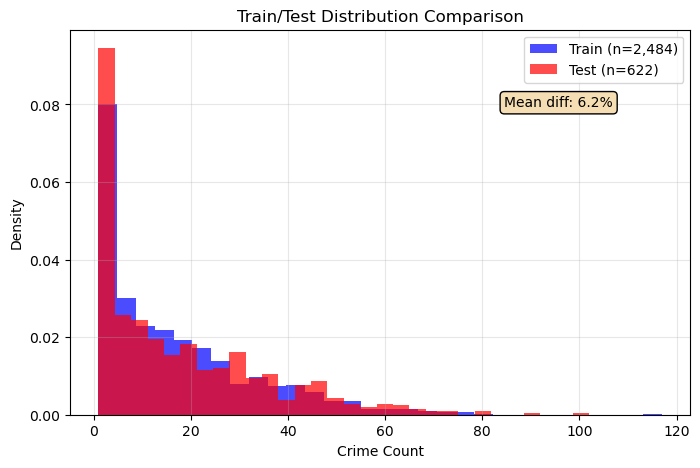

Building preprocessor with:
  Temporal columns (no polynomial): ['offense_year', 'offense_month']
  Numerical columns (with interactions): []
  Categorical columns: ['neighborhood', 'precinct', 'sector']
  Ordinal columns (with order): ['median_household_income_bin', 'total_population_bin', 'median_home_value_bin', 'white_bin', 'black_bin', 'asian_bin', 'hispanic_bin', 'native_american_bin', 'pacific_islander_bin', 'other_race_bin']
  OneHot columns (no order): ['neighborhood', 'precinct', 'sector']

--- Running GridSearch for Dummy Baseline ---

Best params for Dummy Baseline: {'regressor__strategy': 'mean'}
Best CV RMSE: 16.21

--- Dummy Baseline ---
Train RMSE: 16.22
Test RMSE : 17.63

--- Running GridSearch for Ridge Regression ---

Best params for Dummy Baseline: {'regressor__strategy': 'mean'}
Best CV RMSE: 16.21

--- Dummy Baseline ---
Train RMSE: 16.22
Test RMSE : 17.63

--- Running GridSearch for Ridge Regression ---

Best params for Ridge Regression: {'regressor__alpha': 1.0}

<Figure size 640x480 with 0 Axes>

In [40]:
train_size = 0.8
poly_degree = 2

# 1. Data prep
def prepare_data(data, target_column='crime_count', drop_columns=[]):
    drop_columns = [col for col in drop_columns if col in data.columns]
    
    X = data.drop(columns=[target_column] + drop_columns)
    y = data[target_column]

    all_numerical_cols = X.select_dtypes(include=[np.number]).columns
    all_categorical_cols = X.select_dtypes(include=['object']).columns
    
    # Filter out temporal columns first
    temporal_cols = [col for col in all_numerical_cols if any(term in col.lower() 
                    for term in ['month', 'year', 'day', 'hour', 'weekday', 'timestamp'])]
    
    # Find binned columns in categorical data (these are ordinal)
    ordinal_cols = [col for col in all_categorical_cols if col.endswith('_bin')]
    
    # Also check for binned columns that might be in numerical_cols due to dtype issues
    bin_cols_in_numerical = [col for col in all_numerical_cols if col.endswith('_bin')]
    
    # Now numerical_cols contains only non-temporal, non-binned numerical columns
    numerical_cols = [col for col in all_numerical_cols if col not in temporal_cols and col not in bin_cols_in_numerical]

    # Move any binned columns from numerical to ordinal
    ordinal_cols.extend(bin_cols_in_numerical)
    
    # Remove ordinal columns from categorical columns
    categorical_cols = [col for col in all_categorical_cols if col not in ordinal_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)

    print(f"Categorical columns: {list(categorical_cols)}")
    print(f"Ordinal columns: {list(ordinal_cols)}")
    print(f"Temporal columns: {list(temporal_cols)}")
    print(f"Numerical columns: {list(numerical_cols)}")
    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Target variable (y) statistics:")
    print(f"  Mean: {y.mean():.2f}")
    print(f"  Std: {y.std():.2f}")
    print(f"  Min: {y.min()}")
    print(f"  Max: {y.max()}")

    return X_train, X_test, y_train, y_test, temporal_cols, numerical_cols, categorical_cols, ordinal_cols

# 2. Preprocessor
def create_preprocessor(temporal_cols, numerical_cols, categorical_cols, ordinal_cols=None):
    print(f"Building preprocessor with:")
    print(f"  Temporal columns (no polynomial): {list(temporal_cols)}")
    print(f"  Numerical columns (with interactions): {list(numerical_cols)}")
    print(f"  Categorical columns: {list(categorical_cols)}")
    
    # Handle ordinal columns
    if ordinal_cols is None:
        ordinal_cols = []
    
    # FIX: Don't re-filter here - prepare_data already separated them correctly
    ordinal_columns = ordinal_cols  # Use directly
    onehot_columns = categorical_cols  # Use directly
    
    print(f"  Ordinal columns (with order): {list(ordinal_columns)}")
    print(f"  OneHot columns (no order): {list(onehot_columns)}")
    
    # Pipeline for temporal features (no polynomial transformation)
    temporal_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),
        StandardScaler()
    )
    
    # Pipeline for numerical features (with polynomial transformation if any exist)
    if len(numerical_cols) > 0:
        numeric_pipeline = make_pipeline(
            SimpleImputer(strategy='constant', fill_value=0),
            StandardScaler(),
            PolynomialFeatures(
                degree=poly_degree, 
                interaction_only=True,
                include_bias=False
            )
        )
    
    # Ordinal pipeline for ordered categorical variables
    ordinal_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OrdinalEncoder(
            handle_unknown='use_encoded_value',
            unknown_value=-1
        )
    )
    
    # OneHot pipeline for non-ordered categorical variables
    onehot_pipeline = make_pipeline(
        SimpleImputer(strategy='constant', fill_value='missing'),
        OneHotEncoder(
            drop='if_binary',
            handle_unknown='ignore',
            sparse_output=False,
            feature_name_combiner=lambda feature, category: f"{feature}${category}"
        )
    )
    
    # Build transformers list
    transformers = []
    
    # Add transformers based on what columns exist
    if len(temporal_cols) > 0:
        transformers.append(('temporal', temporal_pipeline, temporal_cols))
    if len(numerical_cols) > 0:
        transformers.append(('num', numeric_pipeline, numerical_cols))
    if len(ordinal_columns) > 0:
        transformers.append(('ordinal', ordinal_pipeline, ordinal_columns))
    if len(onehot_columns) > 0:
        transformers.append(('onehot', onehot_pipeline, onehot_columns))
    
    return ColumnTransformer(
        transformers=transformers,
        remainder="passthrough"
    )

# 3. Pipeline builder
def build_pipeline(regressor, preprocessor):
    steps = [('preprocessor', preprocessor)]
    steps.append(('regressor', regressor))
    return Pipeline(steps=steps)

# 4. GridSearch
def run_grid_search(model_name, regressor, param_grid, preprocessor, X_train, y_train):
    pipeline = build_pipeline(regressor, preprocessor)
    grid = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        n_jobs=1,
        cv=5,
        error_score='raise'
    )
    grid.fit(X_train, y_train)
    print(f"\nBest params for {model_name}: {grid.best_params_}")
    print(f"Best CV RMSE: {abs(grid.best_score_):.2f}")
    return grid.best_estimator_

# 5. Evaluate model
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, model_name="Model"):
    pipeline.fit(X_train, y_train)
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print(f"\n--- {model_name} ---")
    print(f"Train RMSE: {rmse_train:.2f}")
    print(f"Test RMSE : {rmse_test:.2f}")
    return {
        "model": model_name,
        "rmse_train": rmse_train,
        "rmse_test": rmse_test,
        "y_train_true": y_train,
        "y_train_pred": y_pred_train,
        "y_test_true": y_test,
        "y_test_pred": y_pred_test
    }

def plot_train_test_distributions(X_train, X_test, y_train, y_test):
    """Simple train/test distribution comparison"""
    
    plt.figure(figsize=(8, 5))
    plt.hist(y_train, bins=30, alpha=0.7, label=f'Train (n={len(y_train):,})', 
             color='blue', density=True)
    plt.hist(y_test, bins=30, alpha=0.7, label=f'Test (n={len(y_test):,})', 
             color='red', density=True)
    
    plt.title('Train/Test Distribution Comparison')
    plt.xlabel('Crime Count')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add summary stats as text
    mean_diff = abs(y_train.mean() - y_test.mean()) / y_train.mean() * 100
    plt.text(0.7, 0.8, f'Mean diff: {mean_diff:.1f}%', 
             transform=plt.gca().transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
    
    plt.show()
    plt.savefig(f'images/trainvstest.png')

# Regressors + hyperparameters  
alphas = np.array([
    0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0
])
print(f"Alpha values for regularization ({len(alphas)} unique values): {', '.join(f'{alpha:.2f}' for alpha in alphas)}")
models_with_params = {
    "Dummy Baseline": {
        "regressor": DummyRegressor(),
        "params": {
            "regressor__strategy": ['mean']
        }
    },
    "Ridge Regression": {
        "regressor": Ridge(), # L2 regularization
        "params": {"regressor__alpha": alphas}, # regularization strength
    },
    "Lasso Regression": {
        "regressor": Lasso(max_iter=1000, tol=1e-3), # L1 regularization
        "params": {"regressor__alpha": alphas}, # regularization strength
    },
    "RandomForest": {
        "regressor": RandomForestRegressor(),
        "params": {
            "regressor__n_estimators": [50, 100], # number of trees
            "regressor__max_depth": [10, 20, None], # max depth of each tree
            "regressor__min_samples_split": [5, 10], # min samples to split
            "regressor__min_samples_leaf": [2, 4], # min samples in leaf
            "regressor__max_features": ['log2'] # feature subsampling
        }
    },
    "GradientBoosting": {
        "regressor": GradientBoostingRegressor(random_state=42),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [3, 5, 7],
            "regressor__learning_rate": [0.01, 0.1, 0.3],
            "regressor__subsample": [0.8, 1.0]
        }
    },
    "XGBoost": {
        "regressor": XGBRegressor(random_state=42, eval_metric='rmse'),
        "params": {
            "regressor__n_estimators": [50, 100],
            "regressor__max_depth": [3, 5, 7],
            "regressor__learning_rate": [0.01, 0.1, 0.3],
            "regressor__subsample": [0.8, 1.0],
            "regressor__colsample_bytree": [0.8, 1.0]
        }
    },
    "AdaBoost": {
        "regressor": AdaBoostRegressor(),
        "params": {
            "regressor__n_estimators": [50, 100], # number of weak learners
            "regressor__learning_rate": [0.01, 0.1, 1.0], # step size
            "regressor__loss": ['linear', 'square'] # loss function
        }
    }
}

# --- MAIN EXECUTION ---
X_train, X_test, y_train, y_test, temporal_cols, num_cols, cat_cols, ordinal_cols = prepare_data(area_monthly_crimes)
plot_train_test_distributions(X_train, X_test, y_train, y_test)
preprocessor = create_preprocessor(temporal_cols, num_cols, cat_cols, ordinal_cols=ordinal_cols)

resultsList = []
predictions = {}
for name, config in models_with_params.items():
    print(f"\n--- Running GridSearch for {name} ---")
    best_model_pipe = run_grid_search(
        model_name=name,
        regressor=config["regressor"],
        param_grid=config["params"],
        preprocessor=preprocessor,
        X_train=X_train,
        y_train=y_train
    )
    result = evaluate_model(best_model_pipe, X_train, X_test, y_train, y_test, model_name=name)
    predictions[result["model"]] = {
        "pipe": best_model_pipe,
        "model": result["model"],
        "rmse_train": result["rmse_train"],
        "rmse_test": result["rmse_test"],
        "y_train_true": result["y_train_true"],
        "y_train_pred": result["y_train_pred"],
        "y_test_true": result["y_test_true"],
        "y_test_pred": result["y_test_pred"]
    }

### Evaluate Models

**Goal:** Compare all trained models and identify the best performer for crime prediction.

**Metrics:** RMSE, R², MAE, and overfitting detection (train vs test performance)

**Analysis:**
- **Performance comparison** - Side-by-side RMSE across all models
- **Model validation** - Actual vs predicted plots with fit quality
- **Feature importance** - Which factors most influence crime predictions
  - Linear models: Coefficient direction (+ increases, - decreases crime)
  - Tree models: Importance rankings by prediction contribution
- **Best model selection** - Automatic identification with actionable insights

**Output:** Top performing model with key factors affecting Seattle crime patterns.

Model Performance Summary:
                  rmse_train  rmse_test  overfitting
model                                               
Dummy Baseline        16.220     17.635        1.415
Ridge Regression      11.883     13.384        1.501
Lasso Regression      11.875     13.362        1.487
RandomForest           5.437      8.119        2.683
GradientBoosting       4.177      7.837        3.660
XGBoost                4.730      7.568        2.839
AdaBoost              14.131     15.360        1.229


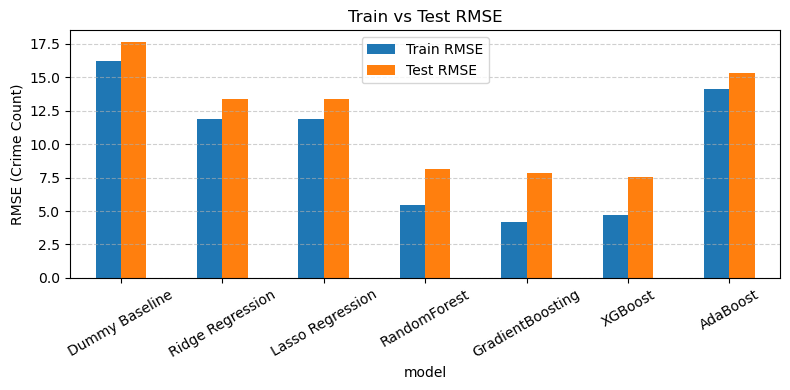


Dummy Baseline:


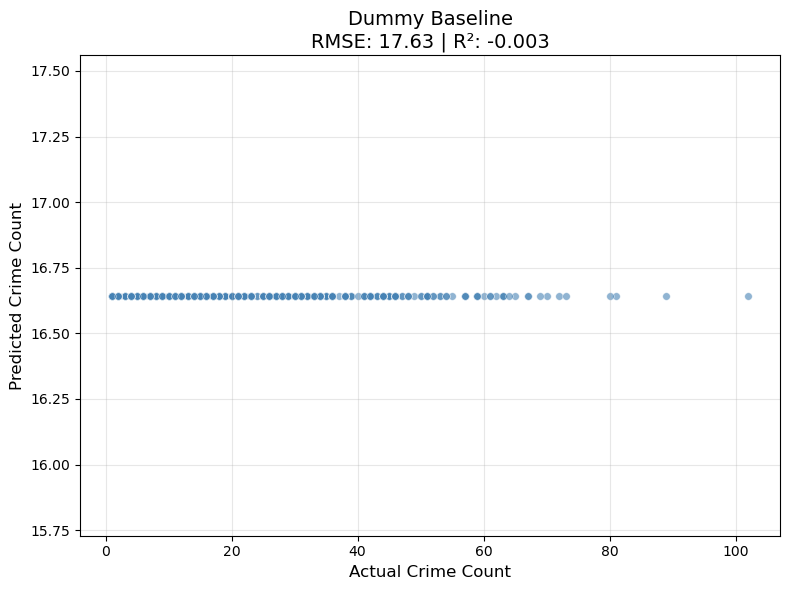


Ridge Regression:


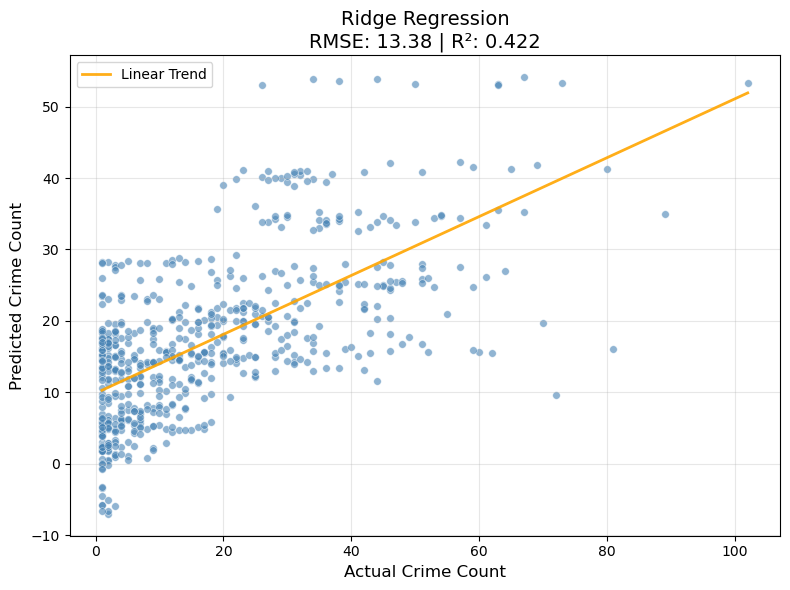

Top 25 Features:
 1. onehot__neighborhood$NORTH BEACON HILL   | +33.9276 INCREASES
 2. onehot__neighborhood$PIONEER SQUARE      | +22.4149 INCREASES
 3. onehot__neighborhood$SANDPOINT           | +21.8365 INCREASES
 4. onehot__neighborhood$ROOSEVELT/RAVENNA   | -17.1568 DECREASES
 5. onehot__sector$W                         | -16.1618 DECREASES
 6. onehot__sector$G                         | +14.0693 INCREASES
 7. onehot__neighborhood$DOWNTOWN COMMERCIAL | -13.8066 DECREASES
 8. onehot__neighborhood$BRIGHTON/DUNLAP     | +12.5710 INCREASES
 9. onehot__neighborhood$ROXHILL/WESTWOOD/ARBOR HEIGHTS | +12.4360 INCREASES
10. onehot__neighborhood$LAKEWOOD/SEWARD PARK | -12.4058 DECREASES
11. onehot__neighborhood$COLUMBIA CITY       | -10.3889 DECREASES
12. onehot__neighborhood$FIRST HILL          | +10.3167 INCREASES
13. onehot__neighborhood$COMMERCIAL DUWAMISH |  -9.8262 DECREASES
14. onehot__neighborhood$MILLER PARK         |  -9.1932 DECREASES
15. onehot__neighborhood$UNKNOWN             | 

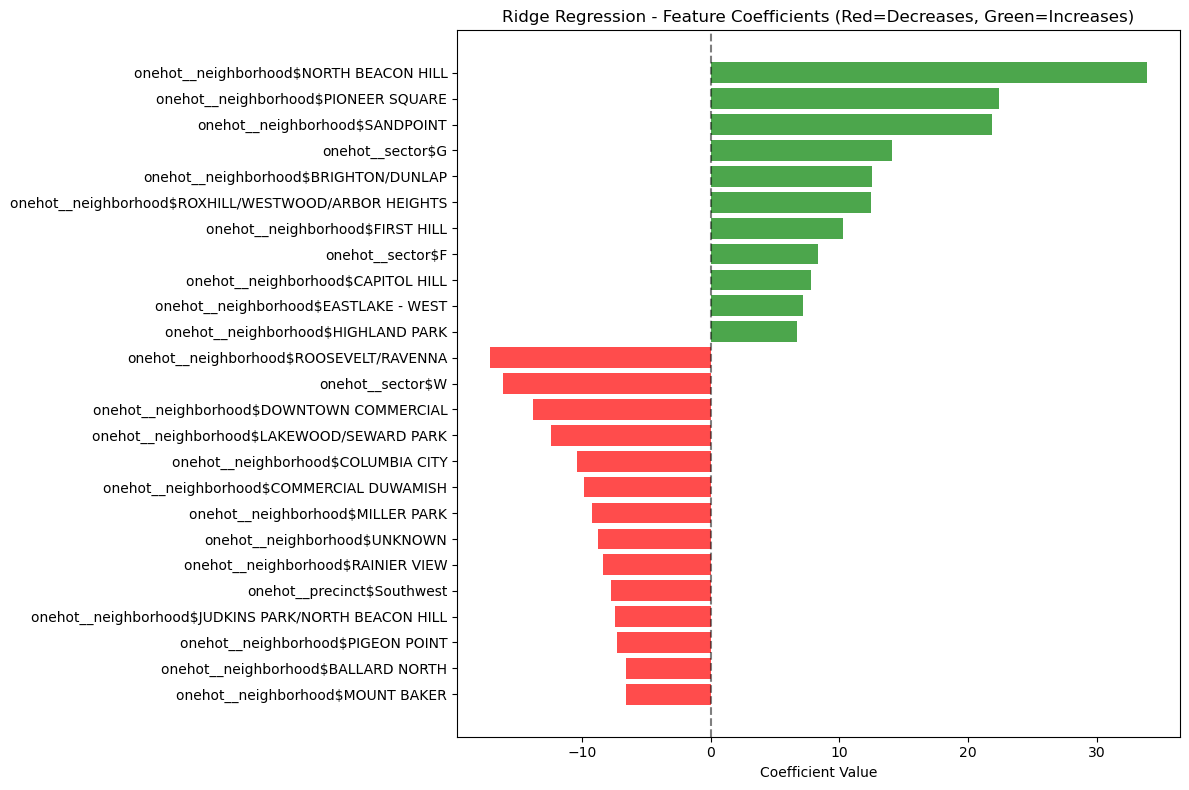


Lasso Regression:


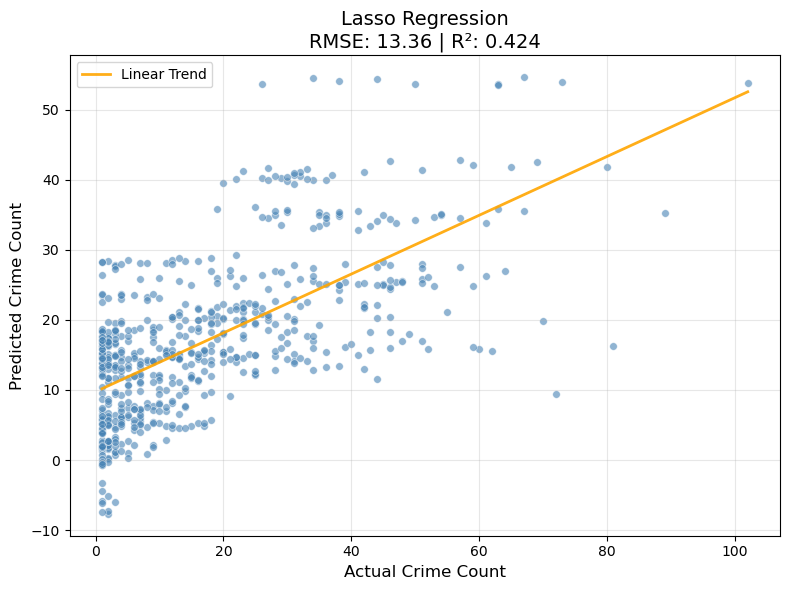

Top 25 Features:
 1. onehot__neighborhood$NORTH BEACON HILL   | +39.2966 INCREASES
 2. onehot__neighborhood$PIONEER SQUARE      | +28.4459 INCREASES
 3. onehot__neighborhood$SANDPOINT           | +28.1319 INCREASES
 4. onehot__sector$W                         | -25.4538 DECREASES
 5. onehot__sector$G                         | +19.8286 INCREASES
 6. onehot__neighborhood$ROXHILL/WESTWOOD/ARBOR HEIGHTS | +18.8121 INCREASES
 7. onehot__neighborhood$MILLER PARK         | -16.8531 DECREASES
 8. onehot__neighborhood$QUEEN ANNE          | +15.7343 INCREASES
 9. onehot__neighborhood$BRIGHTON/DUNLAP     | +15.4578 INCREASES
10. onehot__neighborhood$ROOSEVELT/RAVENNA   | -15.2681 DECREASES
11. onehot__neighborhood$WALLINGFORD         | +14.9160 INCREASES
12. onehot__neighborhood$HIGHLAND PARK       | +12.8871 INCREASES
13. onehot__neighborhood$NORTH DELRIDGE      | +11.8974 INCREASES
14. onehot__neighborhood$SOUTH PARK          | +11.3418 INCREASES
15. onehot__neighborhood$LAKEWOOD/SEWARD PARK | 

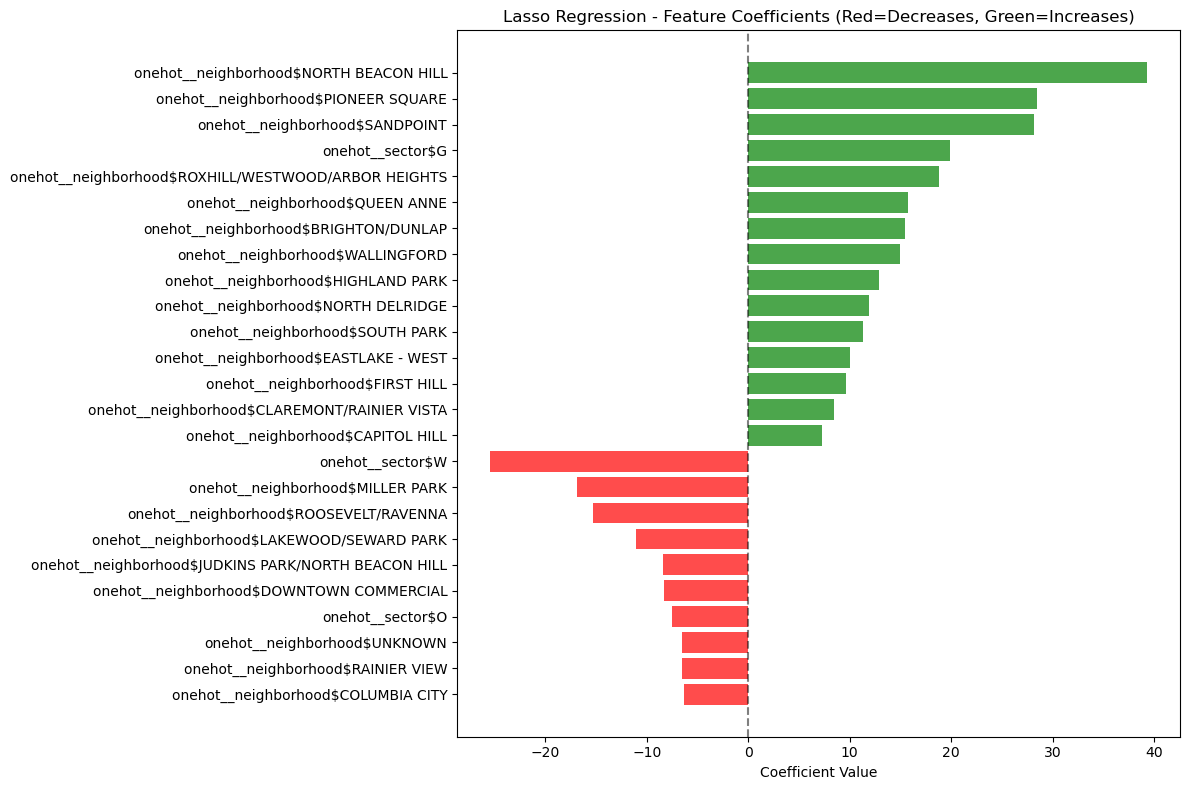


RandomForest:


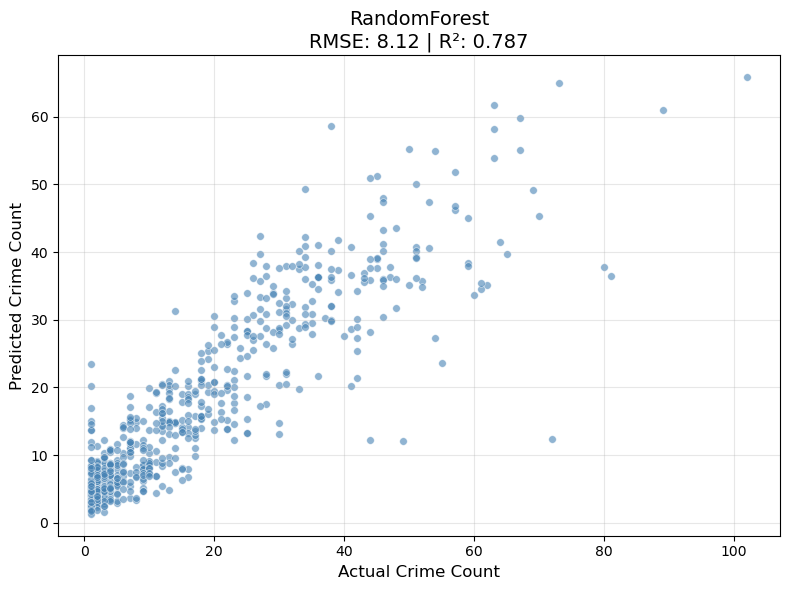

Top 25 Features:
 1. ordinal__total_population_bin            | 0.0796
 2. temporal__offense_month                  | 0.0632
 3. temporal__offense_year                   | 0.0611
 4. onehot__neighborhood$PIONEER SQUARE      | 0.0595
 5. ordinal__median_household_income_bin     | 0.0566
 6. onehot__neighborhood$NORTH BEACON HILL   | 0.0449
 7. ordinal__median_home_value_bin           | 0.0411
 8. ordinal__asian_bin                       | 0.0385
 9. onehot__neighborhood$HIGHLAND PARK       | 0.0348
10. ordinal__black_bin                       | 0.0343
11. onehot__sector$G                         | 0.0335
12. onehot__neighborhood$FIRST HILL          | 0.0282
13. ordinal__hispanic_bin                    | 0.0265
14. onehot__neighborhood$SOUTH PARK          | 0.0230
15. ordinal__white_bin                       | 0.0221
16. onehot__neighborhood$DOWNTOWN COMMERCIAL | 0.0210
17. onehot__sector$E                         | 0.0175
18. onehot__neighborhood$CHINATOWN/INTERNATIONAL DISTRICT | 0.015

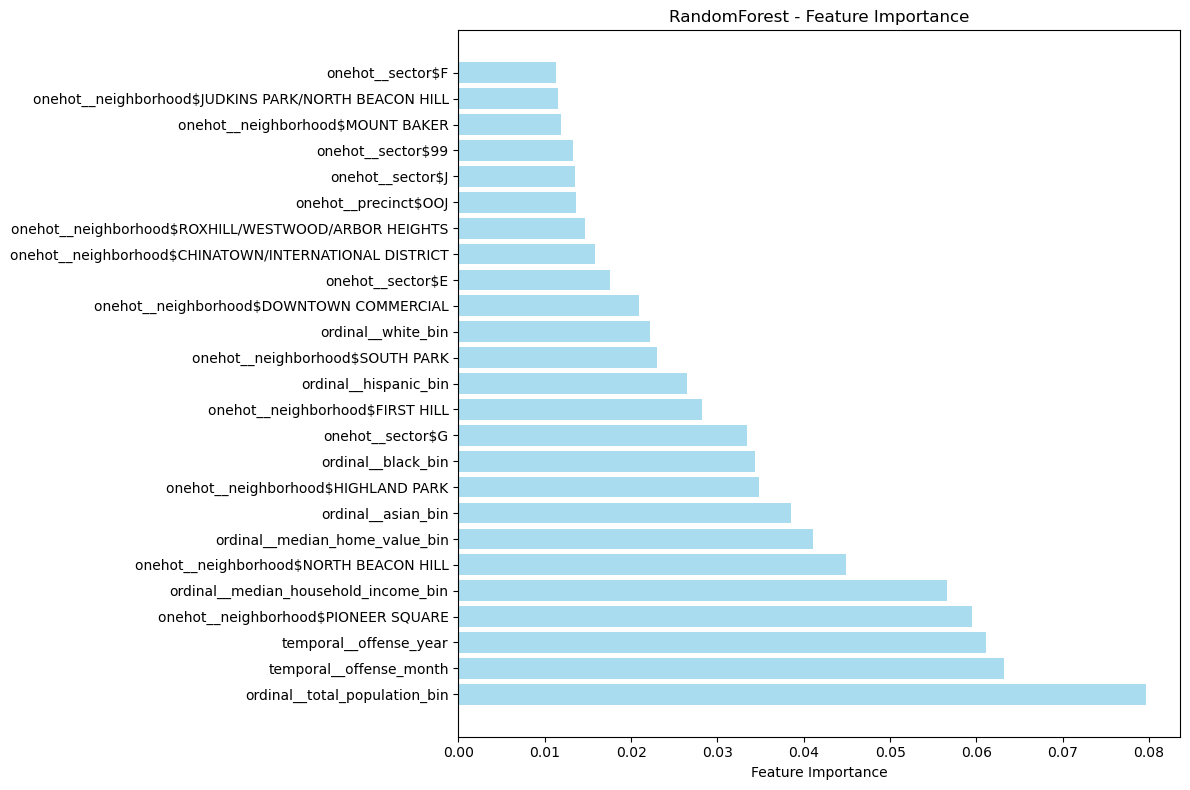


GradientBoosting:


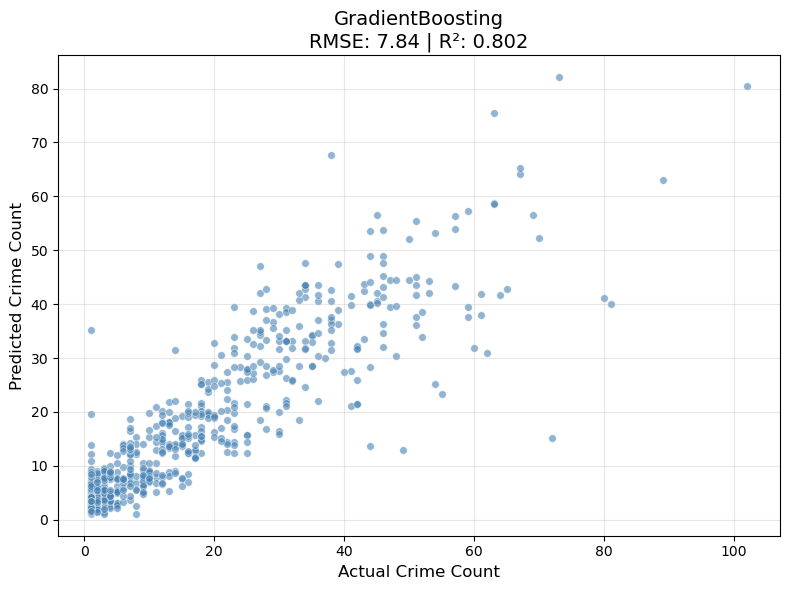

Top 25 Features:
 1. ordinal__total_population_bin            | 0.1318
 2. onehot__neighborhood$PIONEER SQUARE      | 0.0798
 3. temporal__offense_year                   | 0.0694
 4. temporal__offense_month                  | 0.0668
 5. ordinal__median_household_income_bin     | 0.0661
 6. onehot__neighborhood$NORTH BEACON HILL   | 0.0571
 7. onehot__sector$G                         | 0.0423
 8. onehot__neighborhood$CHINATOWN/INTERNATIONAL DISTRICT | 0.0354
 9. ordinal__median_home_value_bin           | 0.0305
10. onehot__neighborhood$HIGHLAND PARK       | 0.0282
11. onehot__sector$J                         | 0.0266
12. onehot__neighborhood$FIRST HILL          | 0.0249
13. onehot__sector$F                         | 0.0222
14. ordinal__hispanic_bin                    | 0.0218
15. ordinal__black_bin                       | 0.0196
16. onehot__neighborhood$BRIGHTON/DUNLAP     | 0.0195
17. ordinal__white_bin                       | 0.0189
18. onehot__neighborhood$ROXHILL/WESTWOOD/ARBOR HEIG

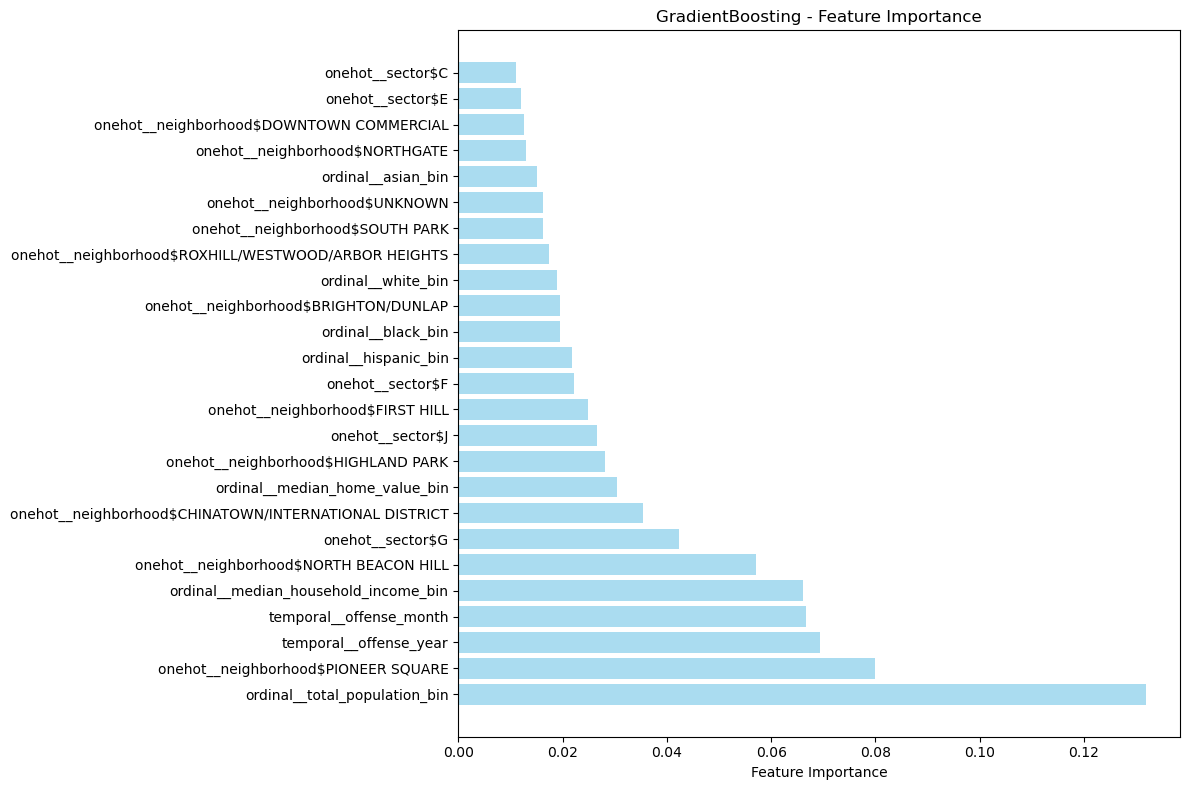


XGBoost:


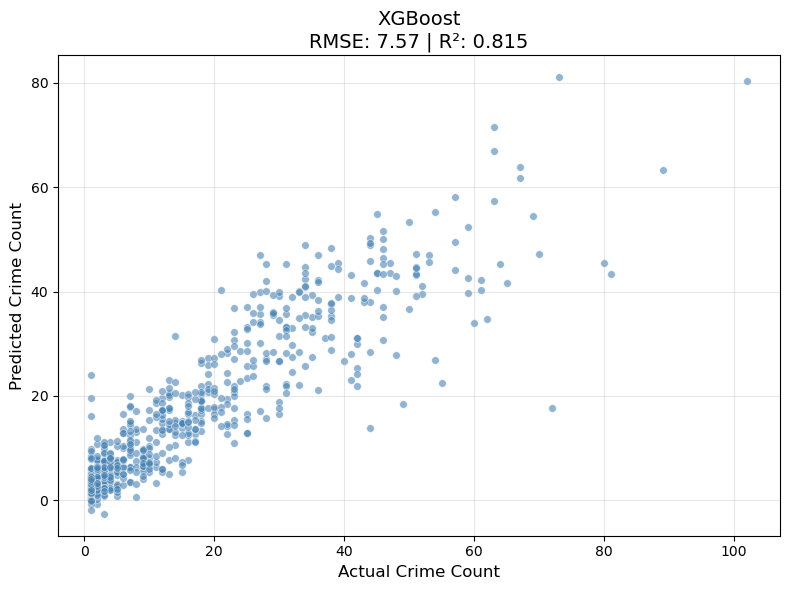

Top 25 Features:
 1. onehot__neighborhood$PIONEER SQUARE      | 0.1630
 2. onehot__neighborhood$NORTH BEACON HILL   | 0.0711
 3. onehot__neighborhood$UNKNOWN             | 0.0628
 4. onehot__sector$G                         | 0.0586
 5. ordinal__total_population_bin            | 0.0438
 6. onehot__neighborhood$FIRST HILL          | 0.0393
 7. onehot__sector$F                         | 0.0377
 8. ordinal__pacific_islander_bin            | 0.0364
 9. onehot__precinct$North                   | 0.0299
10. ordinal__hispanic_bin                    | 0.0298
11. onehot__neighborhood$DOWNTOWN COMMERCIAL | 0.0286
12. onehot__sector$J                         | 0.0261
13. onehot__neighborhood$CHINATOWN/INTERNATIONAL DISTRICT | 0.0261
14. onehot__neighborhood$BRIGHTON/DUNLAP     | 0.0239
15. onehot__sector$R                         | 0.0219
16. onehot__neighborhood$HIGHLAND PARK       | 0.0199
17. onehot__neighborhood$HIGH POINT          | 0.0181
18. onehot__neighborhood$MOUNT BAKER         | 0.017

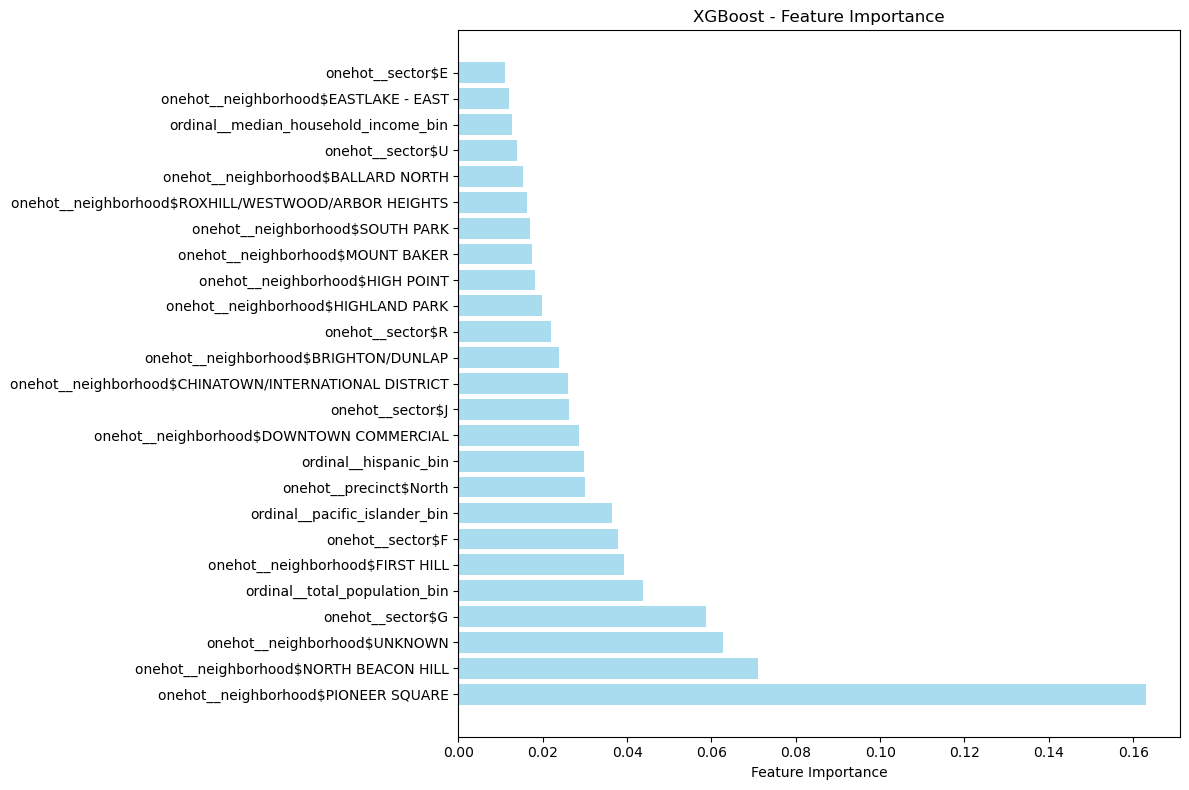


AdaBoost:


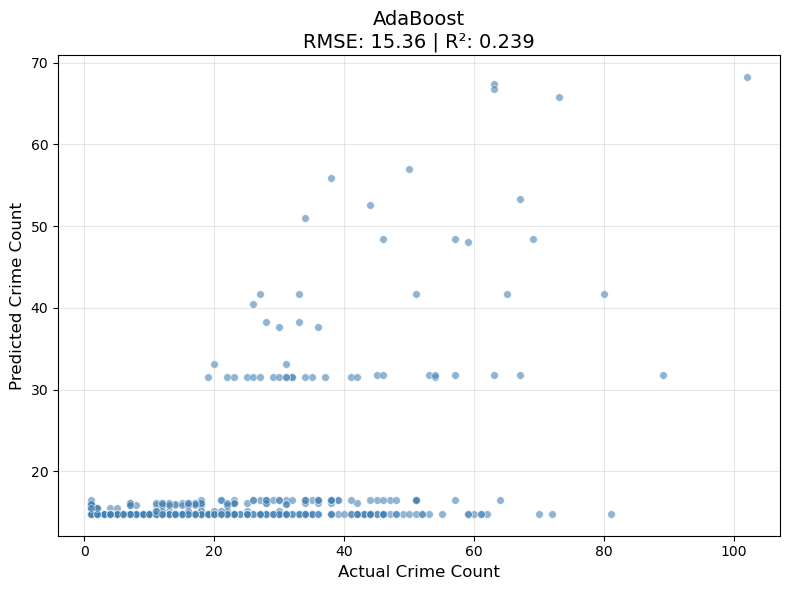

Top 25 Features:
 1. onehot__neighborhood$PIONEER SQUARE      | 0.3251
 2. onehot__neighborhood$NORTH BEACON HILL   | 0.2172
 3. onehot__sector$G                         | 0.1527
 4. ordinal__total_population_bin            | 0.1126
 5. onehot__neighborhood$FIRST HILL          | 0.0452
 6. temporal__offense_year                   | 0.0394
 7. temporal__offense_month                  | 0.0213
 8. onehot__neighborhood$DOWNTOWN COMMERCIAL | 0.0197
 9. onehot__neighborhood$JUDKINS PARK/NORTH BEACON HILL | 0.0189
10. ordinal__median_household_income_bin     | 0.0163
11. onehot__neighborhood$UNKNOWN             | 0.0082
12. onehot__neighborhood$SOUTH PARK          | 0.0076
13. onehot__precinct$Southwest               | 0.0038
14. ordinal__median_home_value_bin           | 0.0025
15. onehot__sector$99                        | 0.0016
16. onehot__precinct$OOJ                     | 0.0015
17. onehot__neighborhood$SANDPOINT           | 0.0013
18. onehot__neighborhood$HIGHLAND PARK       | 0.0013


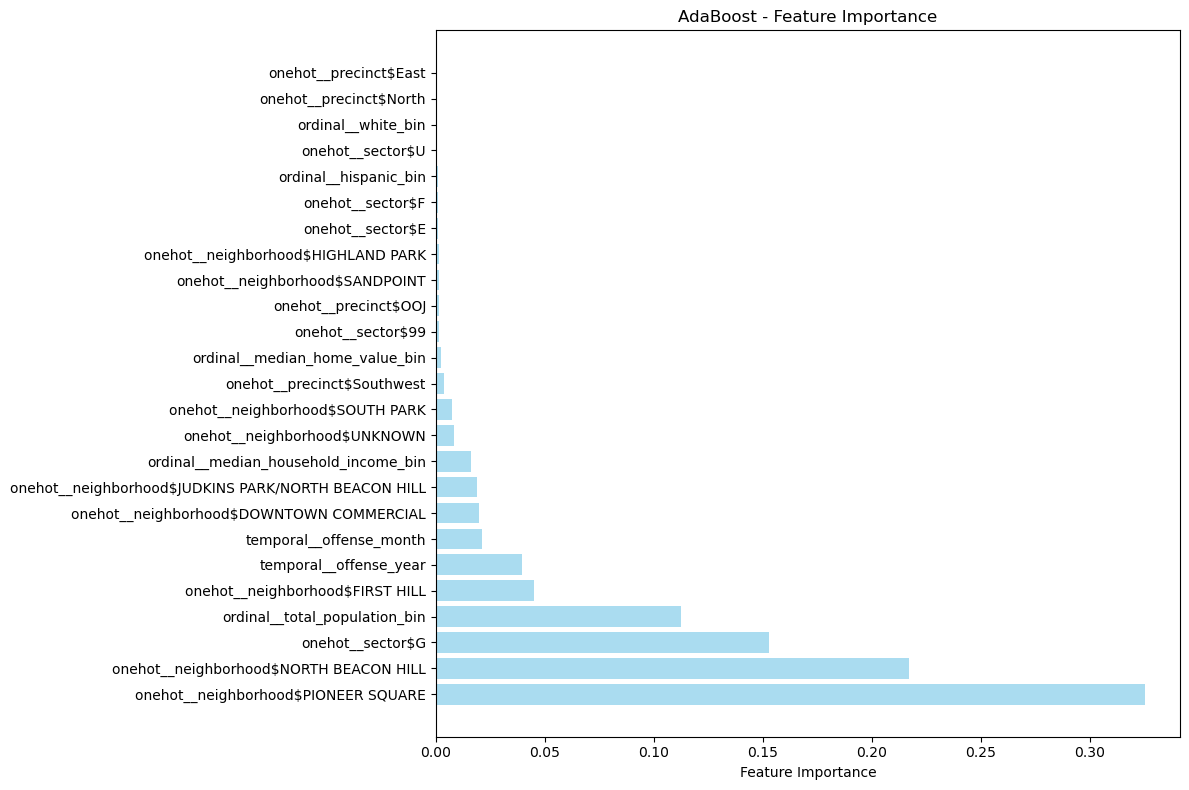


COMPREHENSIVE MODEL COMPARISON TABLE
                  rmse_train  rmse_test     r2     mae  overfitting
XGBoost                4.730      7.568  0.815   5.039        2.839
GradientBoosting       4.177      7.837  0.802   5.068        3.660
RandomForest           5.437      8.119  0.787   5.391        2.683
Lasso Regression      11.875     13.362  0.424   9.752        1.487
Ridge Regression      11.883     13.384  0.422   9.795        1.501
AdaBoost              14.131     15.360  0.239  12.150        1.229
Dummy Baseline        16.220     17.635 -0.003  13.947        1.415

BEST MODEL SUMMARY
Best Model: XGBoost
Test RMSE: 7.568 crimes
R² Score: 0.815 (81.5% variance explained)
MAE: 5.039 crimes
Overfitting: 2.839

CROSS-MODEL FEATURE ANALYSIS

TOP 10 FEATURES APPEARING IN AT LEAST 4/6 MODELS:
 1. onehot__neighborhood$NORTH BEACON HILL             | 12.2691 (6/6 models)
 2. onehot__neighborhood$PIONEER SQUARE                | 8.5813 (6/6 models)
 3. onehot__neighborhood$BRIGHTON/DUNL

In [41]:
# ===========================
# MODELS ANALYSIS
# ===========================

def plot_rmse_comparison(results, figsize=(8, 4), title='Train vs Test RMSE'):
    """Plot comparison of training vs test RMSE for models."""
    rmse_df = pd.DataFrame(results)
    rmse_df = rmse_df.rename(columns={"rmse_train": "Train RMSE", "rmse_test": "Test RMSE"})
    rmse_df = rmse_df.set_index("model")[["Train RMSE", "Test RMSE"]]

    ax = rmse_df.plot(kind='bar', figsize=figsize, title=title)
    plt.ylabel("RMSE (Crime Count)")
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig('images/rmse_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_actual_vs_predicted(y_true, y_pred, model_name):
    """Plot actual vs predicted values with appropriate visualization for model type."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, s=30, color='steelblue', edgecolors='white', linewidth=0.5)

    # Add trend line ONLY for linear models
    if 'Regression' in model_name:  # Ridge Regression, Lasso Regression
        unique_y_true = np.unique(y_true)
        if len(unique_y_true) > 1:
            trend_line = np.poly1d(np.polyfit(y_true, y_pred, 1))(unique_y_true)
            plt.plot(unique_y_true, trend_line, 'orange', linewidth=2, 
                    label='Linear Trend', alpha=0.9)
            plt.legend()

    # Calculate and display metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    plt.xlabel('Actual Crime Count', fontsize=12)
    plt.ylabel('Predicted Crime Count', fontsize=12)
    plt.title(f'{model_name}\nRMSE: {rmse:.2f} | R²: {r2:.3f}', fontsize=14)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    safe_model_name = model_name.replace(' ', '_').replace('/', '_')
    plt.savefig(f'images/actual_vs_predicted_{safe_model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    return rmse, r2

def plot_feature_importance(feature_df, model_name, top_k=25):
    """Plot horizontal bar chart of feature importance with direction, grouped by sign."""
    plt.figure(figsize=(12, 8))
    
    if 'coefficient' in feature_df.columns:
        # Separate and sort by sign
        top_features = feature_df.head(top_k)
        neg_features = top_features[top_features['coefficient'] < 0].sort_values('coefficient', ascending=False)
        pos_features = top_features[top_features['coefficient'] > 0].sort_values('coefficient', ascending=True)
        
        # Combine: negatives first, then positives
        grouped_features = pd.concat([neg_features, pos_features])
        colors = ['red' if x < 0 else 'green' for x in grouped_features['coefficient']]
        
        plt.barh(range(len(grouped_features)), grouped_features['coefficient'], color=colors, alpha=0.7)
        plt.yticks(range(len(grouped_features)), grouped_features['feature'])
        plt.xlabel('Coefficient Value')
        plt.title(f'{model_name} - Feature Coefficients (Red=Decreases, Green=Increases)')
        plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        
    else:
        # Tree models with feature_importances_
        top_features = feature_df.head(top_k)
        plt.barh(range(len(top_features)), top_features['importance'], color='skyblue', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Feature Importance')
    
    plt.tight_layout()
    safe_model_name = model_name.replace(' ', '_').replace('/', '_')
    plt.savefig(f'images/feature_importance_{safe_model_name}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def get_top_common_features(predictions, top_k=10, min_models=4):
    """Find features that consistently rank high across all models."""
    
    model_features = {}
    
    # Extract top features from each model (skip Dummy)
    for model_name, pred_data in predictions.items():
        if 'Dummy' in model_name:
            continue
            
        pipeline = pred_data["pipe"]
        regressor = pipeline.named_steps['regressor']
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        
        if hasattr(regressor, 'coef_'):
            # Linear models - use absolute coefficients
            importances = np.abs(regressor.coef_)
        elif hasattr(regressor, 'feature_importances_'):
            # Tree models
            importances = regressor.feature_importances_
        else:
            continue
        
        # Get top 20 features for this model
        top_indices = np.argsort(importances)[-20:][::-1]
        model_features[model_name] = [(feature_names[i], importances[i]) for i in top_indices]
    
    # Count how many models each feature appears in
    feature_counts = {}
    for model_name, features in model_features.items():
        for feature_name, importance in features:
            if feature_name not in feature_counts:
                feature_counts[feature_name] = {'count': 0, 'total_importance': 0}
            feature_counts[feature_name]['count'] += 1
            feature_counts[feature_name]['total_importance'] += importance
    
    # Find features that appear in ALL models
    num_models = len(model_features)
    common_features = [(name, data['total_importance']/data['count'], data['count']) 
                      for name, data in feature_counts.items() 
                      if data['count'] >= min_models]
    
    # Sort by average importance and take top K
    common_features.sort(key=lambda x: x[1], reverse=True)
    top_common = common_features[:top_k]
    
    print(f"\nTOP {len(top_common)} FEATURES APPEARING IN AT LEAST {min_models}/{num_models} MODELS:")
    print("="*70)
    for i, (feature, avg_importance, model_count) in enumerate(top_common, 1):
        print(f"{i:2d}. {feature[:50]:<50} | {avg_importance:.4f} ({model_count}/{num_models} models)")
    
    return top_common

def comprehensive_analysis(predictions):
    """Complete analysis of all models."""
    
    # 1. Performance comparison
    results = []
    detailed_metrics = {}
    
    for model_name, pred_data in predictions.items():
        y_true = pred_data["y_test_true"]
        y_pred = pred_data["y_test_pred"]
        
        # Calculate additional metrics
        rmse_test = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        mae = np.mean(np.abs(y_true - y_pred))
        
        results.append({
            "model": model_name,
            "rmse_train": pred_data["rmse_train"],
            "rmse_test": pred_data["rmse_test"]
        })
        
        detailed_metrics[model_name] = {
            'rmse_train': pred_data["rmse_train"],
            'rmse_test': rmse_test,
            'r2': r2,
            'mae': mae,
            'overfitting': rmse_test - pred_data["rmse_train"]
        }
    
    # Display basic performance table
    rmse_df = pd.DataFrame(results).set_index("model")
    rmse_df['overfitting'] = rmse_df['rmse_test'] - rmse_df['rmse_train']
    print("Model Performance Summary:")
    print(rmse_df.round(3))
    
    # Plot RMSE comparison
    plot_rmse_comparison(results)
    
    # Actual vs Predicted plots and feature importance
    for model_name, pred_data in predictions.items():
        print(f"\n{model_name}:")
        
        # Performance plot
        plot_actual_vs_predicted(pred_data["y_test_true"], pred_data["y_test_pred"], model_name)
        
        # Feature importance
        pipeline = pred_data["pipe"]
        regressor = pipeline.named_steps['regressor']
        feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        top_features_count = 25
        
        if hasattr(regressor, 'coef_'):
            # Linear models
            coefficients = regressor.coef_
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)

            print(f"Top {top_features_count} Features:")
            for i, (_, row) in enumerate(feature_df.head(top_features_count).iterrows()):
                direction = "INCREASES" if row['coefficient'] > 0 else "DECREASES"
                print(f"{i+1:2d}. {row['feature']:<40} | {row['coefficient']:+8.4f} {direction}")

            plot_feature_importance(feature_df, model_name, top_features_count)

        elif hasattr(regressor, 'feature_importances_'):
            # Tree models
            importances = regressor.feature_importances_
            feature_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)

            print(f"Top {top_features_count} Features:")
            for i, (_, row) in enumerate(feature_df.head(top_features_count).iterrows()):
                print(f"{i+1:2d}. {row['feature']:<40} | {row['importance']:.4f}")

            plot_feature_importance(feature_df, model_name, top_features_count)

    
    
    # Create comprehensive comparison table
    print(f"\n{'='*80}")
    print("COMPREHENSIVE MODEL COMPARISON TABLE")
    print(f"{'='*80}")
    
    comparison_df = pd.DataFrame(detailed_metrics).T
    comparison_df = comparison_df.round(3)
    
    # Sort by test RMSE (best first)
    comparison_df = comparison_df.sort_values('rmse_test')
    
    print(comparison_df)
    
    # 4. Best model summary
    best_model_name = comparison_df.index[0]
    best_metrics = comparison_df.loc[best_model_name]
    
    print(f"\n{'='*60}")
    print("BEST MODEL SUMMARY")
    print(f"{'='*60}")
    print(f"Best Model: {best_model_name}")
    print(f"Test RMSE: {best_metrics['rmse_test']:.3f} crimes")
    print(f"R² Score: {best_metrics['r2']:.3f} ({best_metrics['r2']*100:.1f}% variance explained)")
    print(f"MAE: {best_metrics['mae']:.3f} crimes")
    print(f"Overfitting: {best_metrics['overfitting']:.3f}")
    
    return comparison_df

# Execute analysis
analysis_results = comprehensive_analysis(predictions)

print("\n" + "="*80)
print("CROSS-MODEL FEATURE ANALYSIS")
print("="*80)

common_features = get_top_common_features(predictions, top_k=10)

### Crime Prediction

**Goal:** Generate 12-month crime forecasts using the best-performing model.

**Approach:** Use XGBoost model to predict crime counts at multiple geographic levels.

**Outputs:**
- **Monthly trends** - Citywide forecasts with seasonality
- **Neighborhood rankings** - Top 10 high-risk areas  
- **Precinct allocations** - Resource distribution planning
- **Annual totals** - Year-over-year comparisons

**Result:** Data-driven forecasts for patrol scheduling and resource allocation.

Using best model: XGBoost
Test RMSE: 7.568
Generating crime predictions with best model...
Creating visualizations...
Creating visualizations...


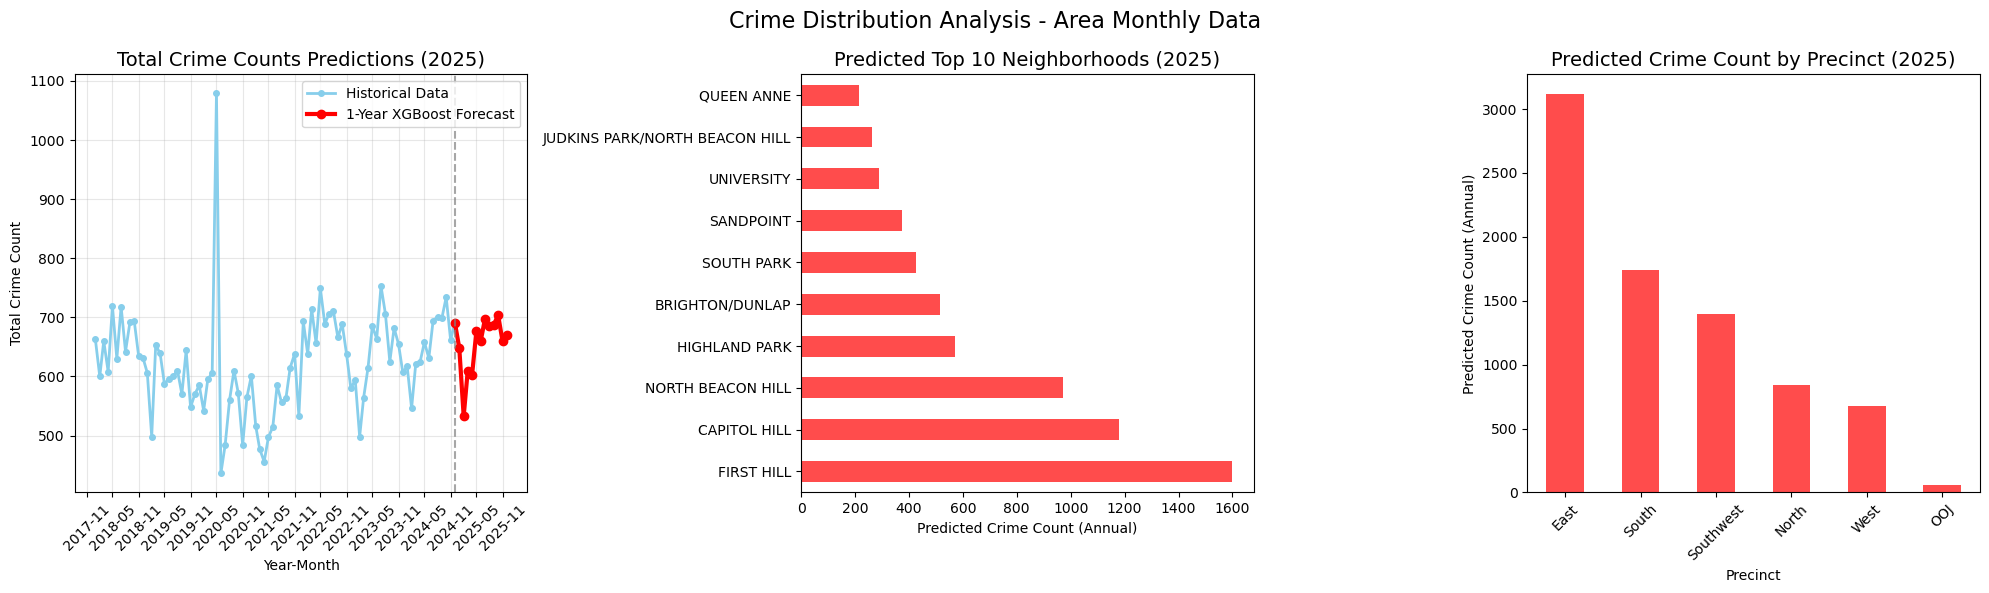

In [42]:
def generate_crime_predictions(area_monthly_crimes, best_model_pipeline, months_ahead=12):
    """Generate crime predictions for future months"""
    # Prepare data
    monthly_totals = area_monthly_crimes.groupby(['offense_year', 'offense_month'])['crime_count'].sum()
    monthly_totals.index = pd.to_datetime(monthly_totals.index.to_series().apply(lambda x: f"{x[0]}-{x[1]:02d}-01"))
    monthly_totals = monthly_totals.sort_index()

    # display(monthly_totals) 
    
    last_date = monthly_totals.index.max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=months_ahead, freq='MS')
    
    feature_cols = [col for col in area_monthly_crimes.columns 
                    if col not in ['crime_count', 'offense_year', 'offense_month']]
    
    future_predictions = []
    neighborhood_predictions = {}
    precinct_predictions = {}
    
    for future_date in future_dates:
        target_month = future_date.month
        latest_year = area_monthly_crimes['offense_year'].max()
        
        # Filter year and month in one shot
        month_combinations = area_monthly_crimes[
            (area_monthly_crimes['offense_year'] == latest_year) &
            (area_monthly_crimes['offense_month'] == target_month)
        ][feature_cols].drop_duplicates().reset_index(drop=True)
        
        if len(month_combinations) == 0:
            future_predictions.append(0)
            continue
        
        # Create prediction dataset
        prediction_data = month_combinations.copy()
        prediction_data['offense_year'] = future_date.year
        prediction_data['offense_month'] = future_date.month
        
        # Predict crime count for each area combination
        area_predictions = best_model_pipeline.predict(prediction_data)
        
        # Store neighborhood-level and precinct-level predictions
        month_key = future_date.strftime('%Y-%m')
        neighborhood_predictions[month_key] = {}
        precinct_predictions[month_key] = {}
        
        for idx, pred in enumerate(area_predictions):
            neighborhood = prediction_data.iloc[idx]['neighborhood']
            precinct = prediction_data.iloc[idx]['precinct']
            
            # Neighborhood predictions
            if neighborhood not in neighborhood_predictions[month_key]:
                neighborhood_predictions[month_key][neighborhood] = 0
            neighborhood_predictions[month_key][neighborhood] += pred
            
            # Precinct predictions
            if precinct not in precinct_predictions[month_key]:
                precinct_predictions[month_key][precinct] = 0
            precinct_predictions[month_key][precinct] += pred
        
        # Aggregate all area predictions to get total monthly prediction
        monthly_total = area_predictions.sum()
        future_predictions.append(monthly_total)
    
    return {
        'monthly_totals': monthly_totals,
        'future_dates': future_dates,
        'future_predictions': future_predictions,
        'neighborhood_predictions': neighborhood_predictions,
        'precinct_predictions': precinct_predictions,
        'last_date': last_date
    }

def aggregate_annual_predictions(predictions_dict, prediction_type='neighborhood'):
    """Aggregate monthly predictions to annual totals by area"""
    predictions_key = f'{prediction_type}_predictions'
    annual_totals = {}
    
    for month_key, areas in predictions_dict[predictions_key].items():
        for area, count in areas.items():
            if area not in annual_totals:
                annual_totals[area] = 0
            annual_totals[area] += count
    
    return pd.Series(annual_totals).sort_values(ascending=False)

def plot_crime_analysis_with_predictions(area_monthly_crimes, predictions_dict, model_name):
    """Create the three-panel crime analysis visualization"""
    import matplotlib.dates as mdates
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle('Crime Distribution Analysis - Area Monthly Data', fontsize=16, y=0.98)
    
    # Extract data from predictions
    monthly_totals = predictions_dict['monthly_totals']
    future_dates = predictions_dict['future_dates']
    future_predictions = predictions_dict['future_predictions']
    last_date = predictions_dict['last_date']
    
    # Plot 1: Monthly trend with predictions
    ax1 = axes[0]
    ax1.plot(monthly_totals.index, monthly_totals.values, color='skyblue', linewidth=2, 
             marker='o', markersize=4, label='Historical Data')
    
    # Connect the lines by including the last historical point with predictions
    connected_dates = [last_date] + list(future_dates)
    connected_predictions = [monthly_totals.iloc[-1]] + future_predictions
    
    # FIXED: Use dynamic model_name instead of hardcoded "RandomForest"
    ax1.plot(connected_dates, connected_predictions, color='red', linewidth=3, 
             marker='o', markersize=6, label=f'1-Year {model_name} Forecast', alpha=1.0)
    
    ax1.axvline(x=last_date, color='gray', linestyle='--', alpha=0.7)
    ax1.set_title('Total Crime Counts Predictions (2025)', fontsize=14)
    ax1.set_xlabel('Year-Month')
    ax1.set_ylabel('Total Crime Count')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Fix x-axis formatting
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Top neighborhoods predictions
    ax2 = axes[1]
    predicted_neighborhood_series = aggregate_annual_predictions(predictions_dict, 'neighborhood').head(10)
    predicted_neighborhood_series.plot(kind='barh', ax=ax2, color='red', alpha=0.7)
    ax2.set_title('Predicted Top 10 Neighborhoods (2025)', fontsize=14)
    ax2.set_xlabel('Predicted Crime Count (Annual)')
    
    # Plot 3: Precinct predictions
    ax3 = axes[2]
    predicted_precinct_series = aggregate_annual_predictions(predictions_dict, 'precinct')
    predicted_precinct_series.plot(kind='bar', ax=ax3, color='red', alpha=0.7)
    ax3.set_title('Predicted Crime Count by Precinct (2025)', fontsize=14)
    ax3.set_xlabel('Precinct')
    ax3.set_ylabel('Predicted Crime Count (Annual)')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig(f'images/crime_prediction.png')
    plt.show()
    
    return predicted_neighborhood_series, predicted_precinct_series

# Get best model name from existing analysis_results (already sorted by best test RMSE)
best_model_name = analysis_results.index[0]
best_model_pipeline = predictions[best_model_name]['pipe']

print(f"Using best model: {best_model_name}")
print(f"Test RMSE: {analysis_results.loc[best_model_name, 'rmse_test']:.3f}")

# Generate predictions with the best model
print("Generating crime predictions with best model...")
prediction_results = generate_crime_predictions(area_monthly_crimes, best_model_pipeline)

print("Creating visualizations...")
top_neighborhoods, top_precincts = plot_crime_analysis_with_predictions(area_monthly_crimes, prediction_results, best_model_name)

In [ ]:
# Seattle Crime Hotspot Map
import folium
import pandas as pd

print("Creating Seattle crime hotspot map...")

# Get neighborhood coordinates and crime totals
neighborhood_coords = main_df.groupby('neighborhood')[['latitude', 'longitude']].mean().dropna()
top_15_neighborhoods = top_neighborhoods.head(15)

# Create map
seattle_map = folium.Map(location=[47.6062, -122.3321], zoom_start=12, tiles='OpenStreetMap')

# Marker configurations
marker_configs = [
    (3, 'red', 'exclamation-triangle', 'HIGH CRIME HOTSPOT'),
    (5, 'darkred', 'fire', 'TOP 5 CRIME AREA'),
    (10, 'orange', 'warning', 'TOP 10 CRIME AREA'),
    (15, 'yellow', 'info', 'TOP 15 CRIME AREA')
]

# Add markers
for neighborhood in top_15_neighborhoods.index:
    if neighborhood in neighborhood_coords.index:
        coords = neighborhood_coords.loc[neighborhood].values
        rank = top_15_neighborhoods.index.get_loc(neighborhood) + 1
        crime_count = top_15_neighborhoods[neighborhood]
        
        # Find appropriate marker config
        for max_rank, color, icon, text in marker_configs:
            if rank <= max_rank:
                break
        
        folium.Marker(
            coords,
            popup=f"<b>{neighborhood}</b><br>{text}<br>Crimes: {crime_count:,}<br>Rank: #{rank}",
            tooltip=f"#{rank}: {neighborhood} ({crime_count:,} crimes)",
            icon=folium.Icon(color=color, icon=icon, prefix='fa')
        ).add_to(seattle_map)

print(f"Added {len([n for n in top_15_neighborhoods.index if n in neighborhood_coords.index])} markers")


# Display the map in the notebook
seattle_map

Creating Seattle crime hotspot map...
Added 10 markers
Interactive map saved as HTML file.


**Note:** The interactive map above may not display properly when viewing this notebook on GitHub. For the best experience, please download and run the notebook locally, or view the static map versions in the `images/` folder.

# What Really Drives Crime in Seattle? A Data Analysis

## Key Findings

After training and comparing six different machine learning models on Seattle crime data, some clear patterns emerged. The XGBoost model performed best, correctly predicting about 82% of crime variations across neighborhoods - which is pretty impressive for something as complex as crime prediction.

Here's what I discovered about what actually drives crime patterns in Seattle:

---

## The Neighborhoods That Stand Out

### Clear Crime Hotspots
Some neighborhoods consistently showed up as high-crime areas across every single model I tested:

- **North Beacon Hill** - This was the strongest predictor in every model. Something about this area makes it particularly prone to crime.
- **Pioneer Square** - Makes sense given its location and mix of tourism, nightlife, and social services
- **First Hill** - The medical district's density and activity levels likely contribute to this pattern

### Other Areas of Concern
A few other neighborhoods appeared as high-crime areas in most models:
- **Highland Park** - Showed up consistently in the tree-based models
- **Brighton/Dunlap** - Another area that multiple models flagged
- **Roxhill/Westwood/Arbor Heights** - This combined area also appeared frequently

### Safer Neighborhoods
On the flip side, some areas consistently showed lower crime rates:
- **Roosevelt/Ravenna** - These models predict 15-17 fewer crimes per month here
- **Lakewood/Seward Park** - Another consistently lower-crime area
- **Miller Park** - Also shows up as having reduced crime activity

## What Demographics Matter Most

### Population Density is King
The biggest predictor after specific neighborhoods? **Population density**. Areas with more people packed together see more crime - this was the top demographic factor in multiple models. Makes sense when you think about it.

### Income Levels Matter Too
**Household income** was consistently the second-most important demographic factor. Lower-income areas tend to have higher crime rates, which aligns with what criminologists have found for decades.

### Timing and Seasons
**Time patterns** are surprisingly important - both the specific year and month matter a lot for predictions. There are definitely seasonal patterns in Seattle crime that the models picked up on.

### Housing Market Stress
**Home values** also play a role - areas with declining or low home values tend to see more crime, likely reflecting broader economic stress in those communities.

### Demographic Composition
The models also found that certain demographic compositions correlate with crime patterns, particularly in areas with higher concentrations of Asian, Hispanic, and Pacific Islander populations. This likely reflects complex socioeconomic factors rather than any direct causation.

## Police Administrative Zones

### The Hot Zone
**Sector G** stood out dramatically - it appeared as a high-crime predictor in every single model, sometimes accounting for up to 14% of the prediction power. Whatever's happening in this administrative zone needs attention.

Other sectors that showed up frequently:
- **Sector F** - Significant in several models
- **Sector J** - Another important administrative zone

The **North Precinct** also appeared as a notable factor, while the **Southwest Precinct** seemed to have some crime-reducing effects.

## The Most Reliable Patterns

When I looked at which factors appeared across ALL six different models, four clear winners emerged:
1. **North Beacon Hill** - Every single model flagged this neighborhood
2. **Pioneer Square** - Universal agreement among models
3. **Sector G** - Administrative hot zone
4. **First Hill** - Consistently problematic

A few other areas showed up in 5 out of 6 models:
- **Downtown Commercial** district
- **Highland Park**
- **South Park**

---

## What This Means for Seattle

### Where to Focus Resources
If I were advising Seattle police on where to concentrate efforts, the data is pretty clear:

**Top Priority Areas:**
- North Beacon Hill and Pioneer Square should get the most attention - every model agreed these are the highest-risk areas
- Sector G needs a closer look at what's driving crime in that administrative zone
- Watch population density changes as an early warning system

**Strategic Timing:**
- Pay attention to seasonal patterns - the models found strong monthly variations
- Use historical year-over-year trends for longer-term planning

### Prevention Opportunities
The demographic patterns suggest some opportunities for prevention:
- High-density, lower-income areas could benefit from targeted community programs
- Areas with declining home values might need economic development initiatives
- Community policing approaches should consider the demographic composition of different neighborhoods

### Using the Model
With 82% accuracy, this XGBoost model could actually be useful for:
- Monthly crime forecasting for resource planning
- Identifying emerging hotspots when neighborhood characteristics change
- Evaluating whether interventions are working in the target areas

---

**Bottom line:** Seattle's crime patterns aren't random - they follow predictable patterns based on location, demographics, and timing. This analysis gives us a data-driven roadmap for where and how to focus crime prevention efforts.